In [43]:
# -*- coding: utf-8 -*-
# ==============================================================================
# BLOQUE 1: IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN GLOBAL
# ==============================================================================
# Descripción: Este bloque contiene todas las importaciones de librerías
# externas necesarias para el script, así como las constantes globales
# y configuraciones iniciales del entorno.
# ------------------------------------------------------------------------------

from Bio import SeqIO, Align
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import pandas as pd
import hgvs.parser
import hgvs.dataproviders.interface
import hgvs.normalizer
import hgvs.exceptions
import hgvs # Aunque los submódulos se importan, a veces hgvs base es útil.
import re
import os

from fpdf import FPDF
from fpdf.enums import XPos, YPos # Para un control más explícito en la generación del PDF.

# Plotly para el Track Viewer interactivo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np


# --- Rutas a archivos de referencia ---
RCRS_FASTA_PATH = "secuencias/NC_012920.1_rCRS.fasta"
RCRS_GENBANK_PATH = "secuencias/NC_012920.1_rCRS.gb"

# --- Definición de regiones Hotspot (para informe en PDF) ---
# Formato: (inicio_1_based, fin_1_based, tipo_hotspot)
HOTSPOT_REGIONS = [
    (16184, 16193, 'indel'), (303, 315, 'indel'), (452, 455, 'indel'),
    (568, 573, 'indel'), (956, 960, 'indel'), (5895, 5899, 'indel'),
    (8272, 8276, 'indel'), (8281, 8285, 'indel')
]

# --- Regiones Hipervariables (HVS) para anotación en Track Viewer ---
# Basado en tu Tabla 1 de la tesis (pág. 6/23)
HVS_REGIONS = [
    {"nombre": "HVS-II", "inicio": 57, "fin": 372},
    {"nombre": "HVS-III", "inicio": 438, "fin": 574},
    {"nombre": "HVS-I", "inicio": 16024, "fin": 16383}
]

# --- Constantes para Nomenclatura SWGDAM/EMPOP ---
POS_3107_BLACKLISTED = 3107 # La posición 3107 no debe reportarse
HVI_C_STRETCH_START = 16182 # Ajustado para incluir inserciones como 16183.1C que EMPOP re-ancla a 16193.1C
HVI_C_STRETCH_END = 16193 # Rango del C-stretch de HVI
INSERTION_199_ANCHOR_RANGE_START = 198 # Rango para inserciones que se anclan a 199
INSERTION_199_ANCHOR_RANGE_END = 199
DELETION_249_ANCHOR_POS = 249 # Posición de anclaje para deleciones en 248/249
HVII_C_STRETCH_START = 302 # Ajustado para incluir inserciones como 302.1C que EMPOP re-ancla a 309.1C
HVII_C_STRETCH_END = 315 # Rango del C-stretch de HVII (considerando 302-310 y 311-315)

RCRS_HVI_C_COUNT_ANCHOR_16189 = 0
RCRS_HVII_C_COUNT_303_309 = 7
RCRS_HVII_C_COUNT_311_315 = 5
INSERTION_291_ANCHOR_POS = 291
INSERTION_291_DETECTION_RANGE_START = 289
INSERTION_291_DETECTION_RANGE_END = 295
AC_REPEAT_MOTIF_START = 513
AC_REPEAT_MOTIF_END = 524
AC_REPEAT_MOTIF_ANCHOR_523 = 523
AC_REPEAT_MOTIF_ANCHOR_524 = 524
MITOMASTER_HVII_DEL_CT_ANCHOR_309 = 309
MITOMASTER_HVI_INS_ANCHOR_16193 = 16193
MITOMASTER_INS_198_ANCHOR = 198
MITOMASTER_INS_291_ANCHOR = 290

# Hotspots de indels que EMPOP ignora por defecto en búsquedas
EMPOP_IGNORED_INDEL_HOTSPOTS_POS = {16193, 309, 455, 463, 573, 960, 5899, 8276, 8285}

# Mapeo de bases IUPAC extendidas (solo las más comunes para variantes)
IUPAC_MIXED_BASES = {
    'R': {'A', 'G'}, 'Y': {'C', 'T'}, 'S': {'G', 'C'}, 'W': {'A', 'T'},
    'K': {'G', 'T'}, 'M': {'A', 'C'}, 'B': {'C', 'G', 'T'}, 'D': {'A', 'G', 'T'},
    'H': {'A', 'C', 'T'}, 'V': {'A', 'C', 'G'}, 'N': {'A', 'C', 'G', 'T'}
}

# --- Constantes para formateo de alineamiento en PDF (y usado en TV tooltip) ---
ALIGNMENT_CONTEXT_WINDOW_PDF = 13 # Bases a cada lado del evento (para PDF)
ALIGNMENT_LABEL_WIDTH_PDF = 7 # Ancho para etiquetas como "Ref:", "Query:" (para PDF)
ALIGNMENT_POS_NUM_WIDTH_PDF = 5 # Ancho para números de posición en el alineamiento (para PDF)

# --- Constantes para formateo de alineamiento en PDF ---
ALIGNMENT_CONTEXT_WINDOW = 13 # Bases a cada lado del evento
ALIGNMENT_LABEL_WIDTH_PDF = 7 # Ancho para etiquetas como "Ref:", "Query:"
ALIGNMENT_POS_NUM_WIDTH_PDF = 5 # Ancho para números de posición en el alineamiento


# --- Mapeos y constantes globales para la extracción y display de Features (rCRS) ---
# Mapeo de códigos de aminoácidos de una letra a tres letras (para referencia interna, no siempre para display)
aa_one_to_three_letter_map = {
    'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys',
    'Q': 'Gln', 'E': 'Glu', 'G': 'Gly', 'H': 'His', 'I': 'Ile',
    'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe', 'P': 'Pro',
    'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'
}

# Mapeo de códigos de aminoácidos de una letra para display en el TV (más conciso)
aa_code_map_for_display = {
    'A': 'A', 'R': 'R', 'N': 'N', 'D': 'D', 'C': 'C',
    'Q': 'Q', 'E': 'E', 'G': 'G', 'H': 'H', 'I': 'I',
    'K': 'K', 'M': 'M', 'F': 'F', 'P': 'P', 'T': 'T',
    'W': 'W', 'Y': 'Y', 'V': 'V',
    'L': 'L', # Por defecto 'L', pero luego veremos L(UUR)/L(CUN)
    'S': 'S'  # Por defecto 'S', pero luego veremos S(UCN)/S(AGY)
}

# Estandarización de nombres de genes codificantes de proteínas (Mitomaster style)
protein_genes_map_short = {
    "MT-CO1": "CO1", "MT-COX1": "CO1", "COI": "CO1", "COX1": "CO1",
    "MT-COII": "CO2", "MT-COX2": "CO2", "COII": "CO2", "COX2": "CO2",
    "MT-COIII": "CO3", "MT-COX3": "CO3", "COIII": "CO3", "COX3": "CO3",
    "MT-CYTB": "CYTB", "MT-CYB": "CYTB", "CYTB": "CYTB", "CYB": "CYTB",
    "MT-ATP8": "ATP8", "MT-ATPASE8": "ATP8", "ATP8": "ATP8", "ATPASE8": "ATP8",
    "MT-ATP6": "ATP6", "MT-ATPASE6": "ATP6", "ATP6": "ATP6", "ATPASE6": "ATP6",
    "MT-ND1":"ND1", "ND1":"ND1", "MT-ND2":"ND2", "ND2":"ND2", "MT-ND3":"ND3", "ND3":"ND3",
    "MT-ND4L":"ND4L", "ND4L":"ND4L", "MT-ND4":"ND4", "ND4":"ND4", "MT-ND5":"ND5", "ND5":"ND5",
    "MT-ND6":"ND6", "ND6":"ND6"
}
protein_genes_final_names = set(protein_genes_map_short.values())

# Orden y mapeo de tipos de pistas finales (controla el eje Y en el TV)
final_track_types_order = ["D-loop", "tRNA", "rRNA", "gene"] # Orden de abajo a arriba en el gráfico

genbank_to_track_type_map = {
    "D-loop": "D-loop",
    "tRNA": "tRNA",
    "rRNA": "rRNA",
    "CDS": "gene",
    "gene": "gene"
}

# --- Definición MAESTRA de Regiones Genómicas de rCRS (BASADA EN LA TESIS) ---
# Esto se usará para construir las features_list en cargar_y_extraer_features_rcrs.
MASTER_RCRS_FEATURES_DEFINITION = [
    # Genes de ARNr (según tu Tabla 1, pág. 7/23 en PDF)
    {"nombre_genbank": "MT-RNR1", "nombre_display": "12S", "tipo": "rRNA", "inicio": 648, "fin": 1601, "hebra": 1},
    {"nombre_genbank": "MT-RNR2", "nombre_display": "16S", "tipo": "rRNA", "inicio": 1671, "fin": 3229, "hebra": 1},

    # Genes de ARNt (según tu Tabla 1 y 2, pág. 6-7/23 en PDF)
    {"nombre_genbank": "MT-TF", "nombre_display": "F", "tipo": "tRNA", "inicio": 577, "fin": 647, "hebra": 1},
    {"nombre_genbank": "MT-TV", "nombre_display": "V", "tipo": "tRNA", "inicio": 1602, "fin": 1670, "hebra": 1},
    {"nombre_genbank": "MT-TL1", "nombre_display": "L(UUR)", "tipo": "tRNA", "inicio": 3230, "fin": 3304, "hebra": 1},
    {"nombre_genbank": "MT-TI", "nombre_display": "I", "tipo": "tRNA", "inicio": 4263, "fin": 4331, "hebra": 1},
    {"nombre_genbank": "MT-TQ", "nombre_display": "Q", "tipo": "tRNA", "inicio": 4329, "fin": 4400, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-TM", "nombre_display": "M", "tipo": "tRNA", "inicio": 4402, "fin": 4469, "hebra": 1},
    {"nombre_genbank": "MT-TW", "nombre_display": "W", "tipo": "tRNA", "inicio": 5512, "fin": 5579, "hebra": 1},
    {"nombre_genbank": "MT-TA", "nombre_display": "A", "tipo": "tRNA", "inicio": 5587, "fin": 5655, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-TN", "nombre_display": "N", "tipo": "tRNA", "inicio": 5657, "fin": 5729, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-TC", "nombre_display": "C", "tipo": "tRNA", "inicio": 5761, "fin": 5826, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-TY", "nombre_display": "Y", "tipo": "tRNA", "inicio": 5826, "fin": 5891, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-TS1", "nombre_display": "S(UCN)", "tipo": "tRNA", "inicio": 7446, "fin": 7514, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-TD", "nombre_display": "D", "tipo": "tRNA", "inicio": 7518, "fin": 7585, "hebra": 1},
    {"nombre_genbank": "MT-TK", "nombre_display": "K", "tipo": "tRNA", "inicio": 8295, "fin": 8364, "hebra": 1},
    {"nombre_genbank": "MT-TG", "nombre_display": "G", "tipo": "tRNA", "inicio": 9991, "fin": 10058, "hebra": 1},
    {"nombre_genbank": "MT-TR", "nombre_display": "R", "tipo": "tRNA", "inicio": 10405, "fin": 10469, "hebra": 1},
    {"nombre_genbank": "MT-TH", "nombre_display": "H", "tipo": "tRNA", "inicio": 12138, "fin": 12206, "hebra": 1},
    {"nombre_genbank": "MT-TS2", "nombre_display": "S(AGY)", "tipo": "tRNA", "inicio": 12207, "fin": 12265, "hebra": 1},
    {"nombre_genbank": "MT-TL2", "nombre_display": "L(CUN)", "tipo": "tRNA", "inicio": 12266, "fin": 12336, "hebra": 1},
    {"nombre_genbank": "MT-TE", "nombre_display": "E", "tipo": "tRNA", "inicio": 14674, "fin": 14742, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-TT", "nombre_display": "T", "tipo": "tRNA", "inicio": 15888, "fin": 15953, "hebra": 1},
    {"nombre_genbank": "MT-TP", "nombre_display": "P", "tipo": "tRNA", "inicio": 15956, "fin": 16023, "hebra": -1}, # Es (L) complementaria

    # Genes codificantes de proteínas (según tu Tabla 1, pág. 6/23 en PDF)
    {"nombre_genbank": "MT-ND1", "nombre_display": "ND1", "tipo": "gene", "inicio": 3307, "fin": 4262, "hebra": 1},
    {"nombre_genbank": "MT-ND2", "nombre_display": "ND2", "tipo": "gene", "inicio": 4470, "fin": 5511, "hebra": 1},
    {"nombre_genbank": "MT-CO1", "nombre_display": "CO1", "tipo": "gene", "inicio": 5904, "fin": 7445, "hebra": 1},
    {"nombre_genbank": "MT-CO2", "nombre_display": "CO2", "tipo": "gene", "inicio": 7586, "fin": 8269, "hebra": 1},
    {"nombre_genbank": "MT-ATP8", "nombre_display": "ATP8", "tipo": "gene", "inicio": 8366, "fin": 8572, "hebra": 1},
    {"nombre_genbank": "MT-ATP6", "nombre_display": "ATP6", "tipo": "gene", "inicio": 8527, "fin": 9207, "hebra": 1},
    {"nombre_genbank": "MT-CO3", "nombre_display": "CO3", "tipo": "gene", "inicio": 9207, "fin": 9990, "hebra": 1},
    {"nombre_genbank": "MT-ND3", "nombre_display": "ND3", "tipo": "gene", "inicio": 10059, "fin": 10404, "hebra": 1},
    {"nombre_genbank": "MT-ND4L", "nombre_display": "ND4L", "tipo": "gene", "inicio": 10470, "fin": 10766, "hebra": 1},
    {"nombre_genbank": "MT-ND4", "nombre_display": "ND4", "tipo": "gene", "inicio": 10760, "fin": 12137, "hebra": 1},
    {"nombre_genbank": "MT-ND5", "nombre_display": "ND5", "tipo": "gene", "inicio": 12337, "fin": 14148, "hebra": 1},
    {"nombre_genbank": "MT-ND6", "nombre_display": "ND6", "tipo": "gene", "inicio": 14149, "fin": 14673, "hebra": -1}, # Es (L) complementaria
    {"nombre_genbank": "MT-CYB", "nombre_display": "CYTB", "tipo": "gene", "inicio": 14747, "fin": 15887, "hebra": 1},
]

In [44]:
# ==============================================================================
# BLOQUE 2: UTILIDADES DE CARGA Y EXTRACCIÓN DE CARACTERÍSTICAS (FEATURES)
# ==============================================================================
# Descripción: Funciones dedicadas a la carga de secuencias desde archivos
# FASTA y a la extracción y procesamiento de características (features)
# desde archivos GenBank, específicamente para la secuencia rCRS.
# Se ha refactorizado la lógica de mapeo de features a tipos de pistas
# para asegurar la correcta clasificación de Genes, rRNAs y tRNAs,
# utilizando las nomenclaturas del GenBank y las de Mitomaster/SWGDAM.
# ------------------------------------------------------------------------------

# --- Tus importaciones y constantes globales del Bloque 1 deben estar arriba ---
# Por ejemplo: from Bio import SeqIO, Align, etc.
# RCRS_FASTA_PATH, RCRS_GENBANK_PATH, etc.

# --- Mapeos y constantes globales para este bloque (asegúrate de que estén aquí) ---
# Mapeo de códigos de aminoácidos de una letra a tres letras (para referencia interna, no siempre para display)
aa_one_to_three_letter_map = {
    'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys',
    'Q': 'Gln', 'E': 'Glu', 'G': 'Gly', 'H': 'His', 'I': 'Ile',
    'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe', 'P': 'Pro',
    'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'
}

# Mapeo de códigos de aminoácidos de una letra para display en el TV (más conciso)
aa_code_map_for_display = {
    'A': 'A', 'R': 'R', 'N': 'N', 'D': 'D', 'C': 'C',
    'Q': 'Q', 'E': 'E', 'G': 'G', 'H': 'H', 'I': 'I',
    'K': 'K', 'M': 'M', 'F': 'F', 'P': 'P', 'T': 'T',
    'W': 'W', 'Y': 'Y', 'V': 'V',
    'L': 'L',
    'S': 'S'
}

# Estandarización de nombres de genes codificantes de proteínas (Mitomaster style)
protein_genes_map_short = {
    "MT-CO1": "CO1", "MT-COX1": "CO1", "COI": "CO1", "COX1": "CO1",
    "MT-COII": "CO2", "MT-COX2": "CO2", "COII": "CO2", "COX2": "CO2",
    "MT-COIII": "CO3", "MT-COX3": "CO3", "COIII": "CO3", "COX3": "CO3",
    "MT-CYTB": "CYTB", "MT-CYB": "CYTB", "CYTB": "CYTB", "CYB": "CYTB",
    "MT-ATP8": "ATP8", "MT-ATPASE8": "ATP8", "ATP8": "ATP8", "ATPASE8": "ATP8",
    "MT-ATP6": "ATP6", "MT-ATPASE6": "ATP6", "ATP6": "ATP6", "ATPASE6": "ATP6",
    "MT-ND1":"ND1", "ND1":"ND1", "MT-ND2":"ND2", "ND2":"ND2", "MT-ND3":"ND3", "ND3":"ND3",
    "MT-ND4L":"ND4L", "ND4L":"ND4L", "MT-ND4":"ND4", "ND4":"ND4", "MT-ND5":"ND5", "ND5":"ND5",
    "MT-ND6":"ND6", "ND6":"ND6"
}
protein_genes_final_names = set(protein_genes_map_short.values())

# Orden y mapeo de tipos de pistas finales (controla el eje Y en el TV)
final_track_types_order = ["D-loop", "tRNA", "rRNA", "gene"] # Orden de abajo a arriba

# Mapeo de tipos de feature del GenBank a los tipos de pista finales
# Esto es para la categorización inicial
genbank_to_track_type_map = {
    "D-loop": "D-loop",
    "tRNA": "tRNA",
    "rRNA": "rRNA",
    "CDS": "gene",
    "gene": "gene"
}


def cargar_secuencia_fasta(ruta_archivo: str, id_esperado: str = None) -> SeqRecord | None:
    """Carga una secuencia desde un archivo FASTA."""
    try:
        record = SeqIO.read(ruta_archivo, "fasta")
        if id_esperado and record.id != id_esperado:
            print(f"Advertencia: El ID ('{record.id}') no coincide con el esperado ('{id_esperado}').")
        print(f"Secuencia '{record.id}' cargada desde '{ruta_archivo}' (Longitud: {len(record.seq)} pb).\n")
        return record
    except FileNotFoundError:
        print(f"Error: No se encontró FASTA en: '{ruta_archivo}'")
        return None
    except ValueError:
        print(f"Error: FASTA '{ruta_archivo}' mal formateado o con >1 secuencia.")
        return None
    except Exception as e:
        print(f"Error al leer '{ruta_archivo}': {e}")
        return None

def cargar_y_extraer_features_rcrs(gb_path: str) -> list:
    """
    Carga un archivo GenBank de rCRS y extrae las características genómicas relevantes,
    estandarizando sus nombres utilizando una definición maestra basada en la tesis,
    incluyendo la hebra y la longitud para el Track Viewer.
    """
    try:
        rcrs_record_gb = SeqIO.read(gb_path, "genbank")
        print(f"Archivo GenBank rCRS '{rcrs_record_gb.id}' cargado. Extrayendo features...")
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo GenBank rCRS en: '{gb_path}'")
        return []
    except Exception as e:
        print(f"Error cargando el archivo GenBank rCRS '{gb_path}': {e}")
        return []

    features_list = []
    
    # Lista para almacenar features que ya hemos "usado" del GenBank para evitar duplicados.
    # Usaremos (type, start, end) para identificar unicidad.
    processed_genbank_features_keys = set()

    # --- 1. Procesar D-loop del GenBank (manejo especial por CompoundLocation) ---
    for feature in rcrs_record_gb.features:
        if feature.type == "D-loop":
            if isinstance(feature.location, CompoundLocation):
                for part_location in feature.location.parts:
                    part_start_1based = int(part_location.start) + 1
                    part_end_1based = int(part_location.end)
                    feature_key = ("D-loop", part_start_1based, part_end_1based)
                    if feature_key not in processed_genbank_features_keys:
                        features_list.append({
                            "nombre": "D-loop",
                            "inicio": part_start_1based,
                            "fin": part_end_1based,
                            "tipo": "D-loop",
                            "hebra": part_location.strand,
                            "longitud": part_end_1based - part_start_1based + 1
                        })
                        processed_genbank_features_keys.add(feature_key)
            else: # Simple D-loop feature
                start_1based = int(feature.location.start) + 1
                end_1based = int(feature.location.end)
                feature_key = ("D-loop", start_1based, end_1based)
                if feature_key not in processed_genbank_features_keys:
                    features_list.append({
                        "nombre": "D-loop",
                        "inicio": start_1based,
                        "fin": end_1based,
                        "tipo": "D-loop",
                        "hebra": feature.location.strand,
                        "longitud": end_1based - start_1based + 1
                    })
                    processed_genbank_features_keys.add(feature_key)
            # No break, ya que puede haber múltiples features de D-loop (aunque rCRS suele tener 1 Compound)
            
    # --- 2. Procesar los Genes, rRNAs y tRNAs de la DEFINICIÓN MAESTRA (TU TESIS) ---
    for master_feat in MASTER_RCRS_FEATURES_DEFINITION:
        display_name = master_feat["nombre_display"]
        final_track_type = master_feat["tipo"]
        start_pos = master_feat["inicio"]
        end_pos = master_feat["fin"]
        hebra_info = master_feat["hebra"]
        
        # Verificar si este feature de la tesis ya fue cubierto por una parte del D-loop GenBank (poco probable)
        feature_key = (final_track_type, start_pos, end_pos)
        if feature_key in processed_genbank_features_keys:
            continue # Ya procesado, saltar

        features_list.append({
            "nombre": display_name,
            "inicio": start_pos,
            "fin": end_pos,
            "tipo": final_track_type,
            "hebra": hebra_info,
            "longitud": end_pos - start_pos + 1
        })
        processed_genbank_features_keys.add(feature_key)


    # --- 3. Ordenar la lista final de features para la visualización ---
    # Re-ordenar por el orden de pista final (final_track_types_order) y luego por posición de inicio.
    features_list.sort(key=lambda x: (final_track_types_order.index(x["tipo"]) if x["tipo"] in final_track_types_order else 99, x["inicio"]))

    print(f"Se extrajeron {len(features_list)} características relevantes de rCRS GenBank.")
    return features_list

In [45]:
# ==============================================================================
# BLOQUE 3: UTILIDADES DE ALINEAMIENTO Y EXTRACCIÓN DE VARIANTES (V4)
# ==============================================================================
# Descripción: Funciones para realizar el alineamiento entre secuencias
# (referencia y consulta) y para extraer las diferencias (variantes crudas)
# a partir del alineamiento resultante.
# SE HA ELIMINADO CÓDIGO REDUNDANTE/MUERTO AL FINAL DE extraer_variantes_crudas.
# ------------------------------------------------------------------------------

def realizar_alineamiento(rcrs_seq: Seq, query_seq: Seq, modo_alineamiento: str = 'local') -> Align.Alignment | None:
    # ... (contenido original sin cambios) ...
    print(f"\\n--- Iniciando Paso 3: Alineamiento en modo '{modo_alineamiento}' ---")
    aligner = Align.PairwiseAligner()
    aligner.mode = modo_alineamiento

    # Matriz de sustitución personalizada (más adecuada para secuencias cercanas o ADN)
    # Puntuaciones: Match=3, Mismatch=-3, N vs Base=1, N vs N=1
    matrix_data = {
        ('A','A'):3, ('A','T'):-3, ('A','G'):-3, ('A','C'):-3, ('A','N'):1,
        ('T','T'):3, ('T','A'):-3, ('T','G'):-3, ('T','C'):-3, ('T','N'):1,
        ('G','G'):3, ('G','A'):-3, ('G','T'):-3, ('G','C'):-3, ('G','N'):1,
        ('C','C'):3, ('C','A'):-3, ('C','T'):-3, ('C','G'):-3, ('C','N'):1,
        ('N','N'):1
    }
    # Asegurar simetría en la matriz
    for k_tuple in list(matrix_data.keys()):
        if (k_tuple[1], k_tuple[0]) not in matrix_data:
            matrix_data[(k_tuple[1], k_tuple[0])] = matrix_data[k_tuple]
    
    custom_matrix = Align.substitution_matrices.Array(data=matrix_data)
    aligner.substitution_matrix = custom_matrix
    
    # Penalizaciones por gap (ajustar según necesidad, estos son valores comunes)
    aligner.open_gap_score = -7.0
    aligner.extend_gap_score = -2.0
    
    print(f"Configuración del alineador: Modo={aligner.mode}, OpenGap={aligner.open_gap_score}, ExtendGap={aligner.extend_gap_score}")

    try:
        alignments = list(aligner.align(rcrs_seq, query_seq)) # Convertir generador a lista
        if alignments:
            best_alignment = alignments[0] # Biopython devuelve el mejor (o uno de los mejores) primero
            print(f"Alineamiento completado. Puntuación: {best_alignment.score}")
            return best_alignment
        else:
            print("No se encontraron alineamientos.")
            return None
    except Exception as e:
        print(f"Ocurrió un error durante el alineamiento: {e}")
        import traceback
        traceback.print_exc()
        return None

def get_substitution_type(ref_base: str, alt_base: str) -> str:
    # ... (contenido original sin cambios) ...
    purines = {'A', 'G'}
    pyrimidines = {'C', 'T'}
    ref_b, alt_b = ref_base.upper(), alt_base.upper()

    if not (ref_b in "ACGTN" and alt_b in "ACGTN"): return "desconocido"
    if ref_b == 'N' or alt_b == 'N': return "substitution (con N)"
    if ref_b == alt_b: return "identico"

    if (ref_b in purines and alt_b in purines) or \
       (ref_b in pyrimidines and alt_b in pyrimidines):
        return "transition"
    elif (ref_b in purines and alt_b in pyrimidines) or \
         (ref_b in pyrimidines and alt_b in purines):
        return "transversion"
    return "substitution"

def extraer_variantes_crudas(alineamiento: Align.Alignment, rcrs_id: str, query_id: str, rcrs_len: int) -> tuple[list, str, str, int, int]:
    print("\\n--- Iniciando Paso 4: Extracción de Variantes Crudas ---")
    
    raw_variants = []
    als_ref = ""
    als_query = ""
    alignment_offset_ref = 0 
    alignment_offset_query = 0 

    # ... (lógica para determinar offsets sin cambios) ...
    if not alineamiento:
        print("Error: Objeto de alineamiento no proporcionado.")
        return raw_variants, als_ref, als_query, alignment_offset_ref, alignment_offset_query

    offset_determinad_con_exito = False
    if hasattr(alineamiento, 'coordinates') and hasattr(alineamiento.coordinates, 'shape'):
        if alineamiento.coordinates.shape[0] >= 1 and alineamiento.coordinates.shape[1] > 0:
            try:
                alignment_offset_ref = int(alineamiento.coordinates[0,0])
                offset_determinad_con_exito = True 
            except (IndexError, TypeError, ValueError) as e:
                print(f"Advertencia: No se pudo extraer offset_ref de coordinates (shape={alineamiento.coordinates.shape}): {e}")
        if alineamiento.coordinates.shape[0] >= 2 and alineamiento.coordinates.shape[1] > 0:
            try:
                alignment_offset_query = int(alineamiento.coordinates[1,0])
            except (IndexError, TypeError, ValueError) as e:
                print(f"Advertencia: No se pudo extraer offset_query de coordinates (shape={alineamiento.coordinates.shape}): {e}")
    
    if not offset_determinad_con_exito and hasattr(alineamiento, 'aligned') and isinstance(alineamiento.aligned, tuple) and len(alineamiento.aligned) == 2:
        print("Información: Intentando obtener offsets desde 'alineamiento.aligned'.")
        if isinstance(alineamiento.aligned[0], tuple) and len(alineamiento.aligned[0]) > 0 and \
           isinstance(alineamiento.aligned[0][0], tuple) and len(alineamiento.aligned[0][0]) == 2:
            try: 
                alignment_offset_ref = alineamiento.aligned[0][0][0]
                offset_determinad_con_exito = True
            except: pass 
        if isinstance(alineamiento.aligned[1], tuple) and len(alineamiento.aligned[1]) > 0 and \
           isinstance(alineamiento.aligned[1][0], tuple) and len(alineamiento.aligned[1][0]) == 2:
            try: alignment_offset_query = alineamiento.aligned[1][0][0]
            except: pass
    
    if not offset_determinad_con_exito:
         print(f"ADVERTENCIA FINAL: No se pudieron determinar los offsets de inicio del alineamiento de forma precisa. Asumiendo offset_ref=0 y offset_query=0.")
         alignment_offset_ref = 0 
         alignment_offset_query = 0

    ref_pos_in_align_segment = 0 
    try:
        als_ref = str(alineamiento[0])
        als_query = str(alineamiento[1])
        if not als_ref or not als_query or len(als_ref) != len(als_query):
            print(f"Error en obtención de secuencias alineadas: Longitudes no coinciden. Ref:{len(als_ref)}, Query:{len(als_query)}")
            return [], "", "", 0, 0 
        
        i = 0
        while i < len(als_ref):
            r_base, q_base = als_ref[i], als_query[i]
            align_col_idx = i 
            consumes_ref_current_char = (r_base != '-')
            current_abs_pos_1_based_ref = alignment_offset_ref + ref_pos_in_align_segment + 1
            
            if r_base != q_base:
                if r_base != '-' and q_base != '-': 
                    var_type = get_substitution_type(r_base, q_base)
                    raw_variants.append({'pos': current_abs_pos_1_based_ref, 'ref': r_base.upper(), 'alt': q_base.upper(), 'type': var_type, 'align_idx': align_col_idx})
                    i += 1
                elif r_base == '-': 
                    ins_seq = ""
                    start_align_idx = align_col_idx
                    insertion_point_ref_pos_0_based = alignment_offset_ref + ref_pos_in_align_segment -1
                    if ref_pos_in_align_segment == 0 and alignment_offset_ref == 0: 
                        insertion_point_ref_pos_0_based = -1 
                    
                    while i < len(als_ref) and als_ref[i] == '-':
                        ins_seq += als_query[i]
                        i += 1
                    raw_variants.append({'pos': insertion_point_ref_pos_0_based, 'ref': '-', 'alt': ins_seq.upper(), 'type': 'insertion', 'align_idx': start_align_idx})
                elif q_base == '-': 
                    del_seq = ""
                    start_align_idx = align_col_idx
                    del_start_abs_pos_1_based = current_abs_pos_1_based_ref
                    temp_ref_pos_tracker_del_segment = ref_pos_in_align_segment 
                    while i < len(als_ref) and als_query[i] == '-':
                        del_seq += als_ref[i]
                        i += 1
                        if als_ref[i-1] != '-':
                             temp_ref_pos_tracker_del_segment +=1 
                    raw_variants.append({'pos': del_start_abs_pos_1_based, 'ref': del_seq.upper(), 'alt': '-', 'type': 'deletion', 'align_idx': start_align_idx})
                    ref_pos_in_align_segment = temp_ref_pos_tracker_del_segment 
                    continue 
            else: 
                i += 1
            
            if consumes_ref_current_char: 
                ref_pos_in_align_segment += 1
        
        print(f"Se encontraron {len(raw_variants)} diferencias crudas (antes de filtrar).")

        # --- INICIO DE LA LÓGICA DE FILTRADO MODIFICADA PARA ARTEFACTOS Y 3107 ---
    
        variants_final_filtradas = [] 
        num_artefactos_filtrados_total = 0
        
        for var_cruda in raw_variants:
            filtrar_esta_variante = False
            
            tipo_var = var_cruda.get('type', '')
            pos_var = var_cruda.get('pos')
            ref_var = var_cruda.get('ref', '').upper()
            alt_var = var_cruda.get('alt', '').upper()

            # Condición 0: Filtrar la posición 3107 según SWGDAM/EMPOP
            if pos_var == POS_3107_BLACKLISTED:
                filtrar_esta_variante = True
                # print(f"DEBUG: Filtrando por Condición 0 (Posición {POS_3107_BLACKLISTED}): {var_cruda}")

            # Condición 1: Artefacto m.3107delN (aunque ya cubierto por Condición 0, lo mantenemos por si acaso)
            elif tipo_var == 'deletion' and pos_var == 3107 and ref_var == 'N':
                filtrar_esta_variante = True
                # print(f"DEBUG: Filtrando por Condición 1 (3107delN): {var_cruda}")

            # Condición 2: Artefacto C3106N (Sustitución C>N en pos 3106)
            # (La rCRS tiene C en 3106. Si la query tiene N allí)
            elif tipo_var.startswith('substitution') and pos_var == 3106 and ref_var == 'C' and alt_var == 'N':
                filtrar_esta_variante = True
                # print(f"DEBUG: Filtrando por Condición 2 (C3106N): {var_cruda}")

            # Condición 3: Artefacto N3107X (Sustitución N>[ACGT] en pos 3107)
            # (La rCRS tiene N en 3107. Si la query tiene una base canónica allí)
            elif tipo_var.startswith('substitution') and pos_var == 3107 and ref_var == 'N' and alt_var in ['A', 'C', 'G', 'T']:
                filtrar_esta_variante = True
                # print(f"DEBUG: Filtrando por Condición 3 (N3107X): {var_cruda}")

            if filtrar_esta_variante:
                num_artefactos_filtrados_total += 1
            else:
                variants_final_filtradas.append(var_cruda)
        
        if num_artefactos_filtrados_total > 0:
            print(f"Se filtraron {num_artefactos_filtrados_total} variantes problemáticas/artefactos (ej. 3107, C3106N, N3107X). Variantes restantes: {len(variants_final_filtradas)}")
        # --- FIN DE LA LÓGICA DE FILTRADO MODIFICADA ---
        
        return variants_final_filtradas, als_ref, als_query, alignment_offset_ref, alignment_offset_query
    
    except Exception as e: # <--- ¡Asegúrate de que este 'except' y su contenido existan y estén al mismo nivel que 'try'!
        print(f"Error extrayendo variantes: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
        return [], "", "", alignment_offset_ref, alignment_offset_query

In [46]:
# ==============================================================================
# BLOQUE 4: ANOTACIÓN DE LOCUS Y UTILIDADES DE HOTSPOT
# ==============================================================================
# Descripción: Funciones para anotar la región o gen mitocondrial afectado
# por una variante y para identificar si una variante cae en una región hotspot.
# ------------------------------------------------------------------------------

def anotar_locus_variante(pos_variante_1based: int, tipo_variante: str, longitud_evento: int, features_rcrs: list) -> str:
    """
    Anota el locus de una variante basándose en su posición y las features de rCRS.
    'longitud_evento' es len(alt) para inserciones/sustituciones, len(ref) para deleciones.
    """
    if not features_rcrs: return "N/A (Features no disponibles)"
    if not isinstance(pos_variante_1based, int) or pos_variante_1based <= 0: return "N/A (Posición inválida)"

    # Determinar el rango de posiciones afectado por la variante en coordenadas 1-based
    start_affected_pos = pos_variante_1based
    end_affected_pos = pos_variante_1based

    if tipo_variante == 'insertion':
        # Una inserción ocurre *después* de pos_variante_1based (si se ancla a la base anterior)
        # o *entre* pos_variante_1based y pos_variante_1based+1.
        # Para la búsqueda de locus, consideramos que afecta el punto de inserción.
        # Si la pos_variante_1based es la base *anterior* a la inserción, entonces la inserción
        # ocurre entre pos_variante_1based y (pos_variante_1based + 1).
        # Consideramos que la variante "toca" ambas posiciones para el solapamiento.
        start_affected_pos = pos_variante_1based 
        end_affected_pos = pos_variante_1based + 1 # El "espacio" donde se inserta
    elif tipo_variante == 'deletion':
        end_affected_pos = pos_variante_1based + longitud_evento - 1
    elif tipo_variante in ["transition", "transversion", "substitution", "substitution (con N)"]:
        # Para sustituciones, solo afecta a la posición dada.
        pass # start_affected_pos y end_affected_pos ya están correctos.
    
    regiones_solapantes = []
    for feature in features_rcrs:
        # Comprobar solapamiento: !(feature_fin < var_inicio || feature_inicio > var_fin)
        if not (feature['fin'] < start_affected_pos or feature['inicio'] > end_affected_pos):
            regiones_solapantes.append(feature)

    if not regiones_solapantes:
        # Si no hay solapamiento directo, buscar regiones intergénicas.
        feature_anterior = None
        feature_siguiente = None
        for f_idx, f_val in enumerate(features_rcrs):
            if f_val['fin'] < start_affected_pos: # Completamente antes
                if feature_anterior is None or f_val['fin'] > feature_anterior['fin']:
                    feature_anterior = f_val
            elif f_val['inicio'] > end_affected_pos: # Completamente después
                if feature_siguiente is None or f_val['inicio'] < feature_siguiente['inicio']:
                    feature_siguiente = f_val
                break # Las features están ordenadas, no es necesario seguir.
        
        if feature_anterior and feature_siguiente:
            # Caso especial: inserción exactamente entre dos genes contiguos
            if tipo_variante == 'insertion' and \
               start_affected_pos == feature_anterior['fin'] and \
               end_affected_pos == feature_siguiente['inicio']:
                return f"Entre ({feature_anterior['nombre']}, {feature_siguiente['nombre']})"
            
            # Si está cerca de ambas, es intergénica. Distancia umbral (e.g. 10bp)
            distancia_intergenica = feature_siguiente['inicio'] - feature_anterior['fin'] -1 
            if 0 <= distancia_intergenica <= 10 : # Espacio intergénico pequeño
                 return f"Intergénica ({feature_anterior['nombre']}-{feature_siguiente['nombre']})"
            else: # Espacio intergénico grande o no definido claramente
                return "Región no anotada (intergénica amplia)"
        elif feature_anterior and start_affected_pos > feature_anterior['fin']:
            return f"Posterior a {feature_anterior['nombre']}"
        elif feature_siguiente and end_affected_pos < feature_siguiente['inicio']:
            return f"Anterior a {feature_siguiente['nombre']}"
        return "Región desconocida (extremos del genoma o error)"

    # Priorizar tipos funcionales (CDS, rRNA, tRNA) si hay múltiples solapamientos
    tipos_prioritarios = ["CDS", "rRNA", "tRNA"]
    regiones_prioritarias = [f['nombre'] for f in regiones_solapantes if f['tipo'] in tipos_prioritarios]
    
    nombres_finales = []
    if regiones_prioritarias:
        nombres_finales = list(set(regiones_prioritarias)) # Nombres únicos
    else: # Si no hay funcionales, usar cualquier tipo de región solapante (e.g. D-loop)
        nombres_finales = list(set(f['nombre'] for f in regiones_solapantes))

    nombres_finales.sort() # Ordenar alfabéticamente para consistencia

    if not nombres_finales: return "Región no anotada (solapamiento sin nombre)"
    return ", ".join(nombres_finales)


def es_variante_en_hotspot(posicion_variante: int, tipo_variante_cruda: str, longitud_evento: int = 1) -> bool:
    """
    Verifica si una variante (indel) cae dentro de una región hotspot definida.
    'posicion_variante' es 1-based. Para inserciones, es la base *anterior*.
    'longitud_evento' es relevante para deleciones.
    """
    if tipo_variante_cruda not in ["insertion", "deletion"]:
        return False
    if not isinstance(posicion_variante, int): return False

    # Las regiones HOTSPOT_REGIONS son 1-based.
    # Para inserciones: la posición 'posicion_variante' es la base 0-based *antes* de la inserción,
    # por lo que la inserción ocurre *después* de (posicion_variante + 1) en 1-based.
    # Para deleciones: 'posicion_variante' es el inicio 1-based de la deleción.
    
    start_affected_region = -1
    end_affected_region = -1

    if tipo_variante_cruda == "insertion":
        # Inserción ocurre *después* de 'posicion_variante' (si 0-based),
        # o entre 'posicion_variante' y 'posicion_variante + 1' (si 1-based).
        # Si la 'posicion_variante' que llega es 0-based (como en variantes crudas),
        # el punto de inserción 1-based es (posicion_variante + 1).
        # El evento de inserción se considera en la "unión" o "gap" entre bases.
        # Para hotspots de indel, se suele referenciar a las bases adyacentes.
        # ej. Inserción en 309.1C -> hotspot 303-315. pos_cruda es 301 (0-based) -> 302 (1-based)
        # Si la 'posicion_variante' es la pos 0-based ANTERIOR (lo que usa 'extraer_variantes_crudas'), entonces el punto de inserción es (posicion_variante + 1)
        # Este es el punto donde se inserta, así que es el que se compara.
        # La 'posicion_variante' que llega a 'generar_tabla_y_exportar' para 'es_variante_en_hotspot'
        # viene de `var_cruda.get('pos')`. Para inserciones, esto es 0-based.
        # Entonces, el punto real de inserción en 1-based es `posicion_variante + 1`.
        point_of_insertion_1based = posicion_variante + 1 
        start_affected_region = point_of_insertion_1based
        end_affected_region = point_of_insertion_1based # Un punto
    elif tipo_variante_cruda == "deletion":
        # 'posicion_variante' es el inicio 1-based de la deleción (como en variantes crudas)
        start_affected_region = posicion_variante
        end_affected_region = posicion_variante + longitud_evento - 1
    
    if start_affected_region == -1: return False

    for hs_start, hs_end, _ in HOTSPOT_REGIONS:
        # Comprobar si la región afectada por la variante [start_affected_region, end_affected_region]
        # solapa con la región hotspot [hs_start, hs_end].
        # Solapamiento si: !(hs_end < start_affected_region || hs_start > end_affected_region)
        if not (hs_end < start_affected_region or hs_start > end_affected_region):
            return True
    return False

def obtener_hvs_region(pos_variante_1based: int) -> str | None:
    """
    Determina si una posición cae en una región hipervariable (HVS-I, HVS-II, HVS-III).
    Retorna el nombre de la región (ej. "HVS-I") o None si no cae en ninguna.
    """
    for hvs in HVS_REGIONS: # HVS_REGIONS debe ser accesible (definido globalmente)
        if hvs["inicio"] <= pos_variante_1based <= hvs["fin"]:
            return hvs["nombre"]
    return None

In [47]:
# ==============================================================================
# BLOQUE 5: PROVEEDOR DE SECUENCIAS HGVS Y NORMALIZACIÓN/FORMATEO (V10)
# ==============================================================================
# Descripción: Incluye la clase LocalSeqProvider, normalización HGVS,
# y formateo Mitomaster/EMPOP.
# SE HAN ELIMINADO PRINTS DE DEPURACIÓN Y AJUSTADO EL MANEJO DE DELECIONES HVII EN MITOMASTER.
# ------------------------------------------------------------------------------

import hgvs.parser
import hgvs.dataproviders.interface
import hgvs.normalizer
import hgvs.exceptions
import re # Para formatear_variantes_empop

class LocalSeqProvider(hgvs.dataproviders.interface.Interface):
    def __init__(self, seq_dict: dict):
        self._seq_dict = seq_dict
        self.source = "local_dict_provider"
    @property
    def data_version(self) -> str: return "1.0"
    @property
    def schema_version(self) -> str: return "1.0"
    def get_seq(self, ac: str, start_i: int = None, end_i: int = None) -> str:
        seq = self._seq_dict.get(ac)
        if seq is None: raise hgvs.exceptions.HGVSDataNotAvailableError(f"Secuencia '{ac}' no encontrada")
        len_seq = len(seq); start = start_i if start_i is not None else 0; end = end_i if end_i is not None else len_seq
        if start < 0: start = len_seq + start
        if end < 0: end = len_seq + end
        start = max(0, start); end = min(len_seq, end)
        if start >= end: return ""
        return seq[start:end]
    # ... (resto de métodos de LocalSeqProvider sin cambios) ...
    def get_assembly_map(self, assembly_name): raise NotImplementedError("get_assembly_map no implementado")
    def get_gene_info(self, gene): raise NotImplementedError("get_gene_info no implementado")
    def get_tx_exons(self, tx_ac, alt_ac, alt_aln_method): raise NotImplementedError("get_tx_exons no implementado")
    def get_tx_for_gene(self, gene): raise NotImplementedError("get_tx_for_gene no implementado")
    def get_tx_identity_info(self, tx_ac): raise NotImplementedError("get_tx_identity_info no implementado")
    def get_tx_info(self, tx_ac, alt_ac, alt_aln_method): raise NotImplementedError("get_tx_info no implementado")
    def get_tx_mapping_options(self, tx_ac): raise NotImplementedError("get_tx_mapping_options no implementado")
    def get_tx_seq(self, tx_ac): raise NotImplementedError("get_tx_seq no implementado")
    def get_acs_for_protein_seq(self, seq): raise NotImplementedError("get_acs_for_protein_seq no implementado")
    def get_similar_transcripts(self, tx_ac): raise NotImplementedError("get_similar_transcripts no implementado")
    def get_tx_for_region(self, alt_ac, alt_aln_method, start_i, end_i): raise NotImplementedError("get_tx_for_region no implementado")
    def get_pro_ac_for_tx_ac(self, tx_ac): raise NotImplementedError("get_pro_ac_for_tx_ac no implementado")
    def get_seq_part(self, ac, start_i=None, end_i=None): return self.get_seq(ac, start_i, end_i)
    def __contains__(self, ac: str) -> bool: return ac in self._seq_dict
    def list_assemblies(self): raise NotImplementedError("list_assemblies no implementado")
    def list_genes(self): raise NotImplementedError("list_genes no implementado")


def normalizar_y_nombrar_hgvs(variantes_crudas: list, ref_accession: str, ref_sequence_str: str) -> list:
    
    print("\n--- Iniciando Paso 5: Nomenclatura y Normalización HGVS ---")
    if not variantes_crudas: return []
    try:
        seq_dict = {ref_accession: ref_sequence_str}
        hdp_local = LocalSeqProvider(seq_dict)
        hp = hgvs.parser.Parser()
        hn = hgvs.normalizer.Normalizer(hdp_local, shuffle_direction=3, cross_boundaries=True)
        normalized_hgvs_strings = []
        print(f"Procesando {len(variantes_crudas)} variantes crudas con HGVS...")
        for i, var_dict in enumerate(variantes_crudas):
            hgvs_string_base = f"{ref_accession}:m."
            hgvs_string_var_part = ""
            try:
                pos_input_cruda = var_dict['pos']; ref_allele = var_dict['ref'].upper()
                alt_allele = var_dict['alt'].upper(); var_type = var_dict['type']
            except KeyError as ke: normalized_hgvs_strings.append(f"ERROR_DATO_FALTANTE_EN_VAR_CRUDA ({ke}): {var_dict}"); continue
            except Exception as e: normalized_hgvs_strings.append(f"ERROR_INESPERADO_EN_VAR_CRUDA ({type(e).__name__}): {var_dict}"); continue
            if var_type in ["transition","transversion","substitution","substitution (con N)"]:
                pos_1based_sub = int(pos_input_cruda)
                if pos_1based_sub <= 0: normalized_hgvs_strings.append(f"ERROR_POS_SUB_INVALIDA ({pos_1based_sub}): {var_dict}"); continue
                hgvs_string_var_part = f"{pos_1based_sub}{ref_allele}>{alt_allele}"
            elif var_type == 'deletion':
                pos_1based_del_start = int(pos_input_cruda)
                if pos_1based_del_start <= 0: normalized_hgvs_strings.append(f"ERROR_POS_DEL_INVALIDA ({pos_1based_del_start}): {var_dict}"); continue
                len_del = len(ref_allele)
                if len_del == 0: normalized_hgvs_strings.append(f"ERROR_DEL_SIN_REF: {var_dict}"); continue
                if len_del > 1: end_pos_del = pos_1based_del_start + len_del - 1; hgvs_string_var_part = f"{pos_1based_del_start}_{end_pos_del}del"
                else: hgvs_string_var_part = f"{pos_1based_del_start}del" 
            elif var_type == 'insertion':
                pos_0based_anterior_ins = int(pos_input_cruda) 
                if pos_0based_anterior_ins < 0: hgvs_pos_anterior_1based = 0; hgvs_pos_siguiente_1based = 1
                else: hgvs_pos_anterior_1based = pos_0based_anterior_ins + 1; hgvs_pos_siguiente_1based = hgvs_pos_anterior_1based + 1
                hgvs_string_var_part = f"{hgvs_pos_anterior_1based}_{hgvs_pos_siguiente_1based}ins{alt_allele}"
            if not hgvs_string_var_part: normalized_hgvs_strings.append(f"UNPROCESSED_FORMAT_HGVS ({var_type}): {var_dict}"); continue
            hgvs_full_string_to_parse = hgvs_string_base + hgvs_string_var_part
            try:
                parsed_variant = hp.parse_hgvs_variant(hgvs_full_string_to_parse)
                normalized_variant = hn.normalize(parsed_variant)
                normalized_hgvs_strings.append(str(normalized_variant))
            except Exception as e_norm: 
                if var_type == 'deletion' and 'pos_1based_del_start' in locals() and len(ref_allele) == 1 and pos_1based_del_start > 0:
                    hgvs_string_var_part_alt_del = f"{pos_1based_del_start}del{ref_allele}" # Intenta formato m.XdelN
                    hgvs_full_string_alt_del = hgvs_string_base + hgvs_string_var_part_alt_del
                    try:
                        parsed_variant_alt = hp.parse_hgvs_variant(hgvs_full_string_alt_del)
                        normalized_variant_alt = hn.normalize(parsed_variant_alt)
                        normalized_hgvs_strings.append(str(normalized_variant_alt) + " (ReintentoDel)")
                    except Exception as e_retry: normalized_hgvs_strings.append(f"{hgvs_full_string_to_parse} (Error HGVS: {type(e_norm).__name__}), ReintentoDel {hgvs_full_string_alt_del} (FALLIDO: {type(e_retry).__name__})")
                else: normalized_hgvs_strings.append(f"{hgvs_full_string_to_parse} (ERROR HGVS General: {type(e_norm).__name__} - {e_norm})")
        print(f"Procesamiento HGVS completado. {len(normalized_hgvs_strings)} variantes procesadas.")
        return normalized_hgvs_strings
    except Exception as e_setup:
        print(f"Error general en la configuración o proceso de normalización HGVS: {e_setup}"); import traceback; traceback.print_exc()
        return [f"ERROR_HGVS_SETUP ({type(e_setup).__name__}): {v}" for v in variantes_crudas]

def formatear_estilo_mitomaster(
    hgvs_norm_strings: list, 
    ref_acc_id: str, 
    ref_sequence_str_original: str, 
    variantes_crudas_originales: list 
) -> list:
    print("\n--- Iniciando Paso 5b: Formateo estilo Mitomaster ---")
    mitomaster_formateadas = []
    if not hgvs_norm_strings: return mitomaster_formateadas

    hp_temp_parser = hgvs.parser.Parser()

    for idx_hgvs, hgvs_norm_string in enumerate(hgvs_norm_strings):
        prefix_to_remove = ref_acc_id + ":m."
        variant_part_hgvs = hgvs_norm_string[len(prefix_to_remove):] if hgvs_norm_string.startswith(prefix_to_remove) else hgvs_norm_string
        formato_final_mitomaster = variant_part_hgvs 

        if any(err_tag in hgvs_norm_string for err_tag in ["ERROR", "UNPROCESSED", "FALLIDO", "FORMATO_"]):
            mitomaster_formateadas.append(hgvs_norm_string)
            continue
        
        var_cruda_actual = None
        original_variant_type_is_insertion = False
        original_inserted_sequence = ""
        original_pos_cruda_0based_ins = -1
        
        # Obtener la variante cruda original asociada al HGVS normalizado
        if idx_hgvs < len(variantes_crudas_originales):
             var_cruda_actual = variantes_crudas_originales[idx_hgvs]
             # Determinar el tipo de variante original (sustitución, deleción, inserción)
             # y la secuencia insertada/deletada para los casos especiales.
             original_variant_type = var_cruda_actual.get('type')
             original_ref_seq_cruda = var_cruda_actual.get('ref', '').upper()
             original_alt_seq_cruda = var_cruda_actual.get('alt', '').upper()
             original_pos_cruda_1based = var_cruda_actual.get('pos') # Asumimos 1-based para Mitomaster

             if original_variant_type == 'insertion':
                 original_variant_type_is_insertion = True
                 original_inserted_sequence = original_alt_seq_cruda
                 original_pos_cruda_0based_ins = var_cruda_actual.get('pos', -1) # Esta es la pos 0-based ANTES de la inserción

        # --- CASOS ESPECIALES DE HOTSPOTS (prioridad sobre HGVS normalizado si es necesario) ---
        # Estos son los que ya tenías para Mitomaster. Se mantienen si son válidos.
        if original_variant_type_is_insertion and var_cruda_actual:
            # Caso 309CCC (C309CCC)
            if original_pos_cruda_0based_ins == 301 and original_inserted_sequence == "CC":
                if 0 <= 308 < len(ref_sequence_str_original) and ref_sequence_str_original[308] == 'C': # C en pos 309
                    formato_final_mitomaster = "C309CCC" 
                    mitomaster_formateadas.append(formato_final_mitomaster)
                    continue 
            # Caso 16193CC (C16193CC)
            elif original_pos_cruda_0based_ins == 16182 and original_inserted_sequence == "C":
                 if 0 <= 16192 < len(ref_sequence_str_original) and ref_sequence_str_original[16192] == 'C': # C en pos 16193
                    formato_final_mitomaster = "C16193CC" 
                    mitomaster_formateadas.append(formato_final_mitomaster)
                    continue
        
        # --- NUEVOS CASOS ESPECIALES DE MITOMASTER (Basados en discrepancias) ---
        # Prueba 1: Deleciones HVII (310d, 316d) -> CT309-, G316C
        if original_variant_type == 'deletion':
            # Si es deleción en 310 (rCRS T), y Mitomaster lo ve como CT309-
            if original_pos_cruda_1based == 310 and original_ref_seq_cruda == 'T':
                # Esto es una asunción, ya que el alineador de Mitomaster reinterpreta
                # una deleción simple a una deleción de bloque CT.
                formato_final_mitomaster = "CT309-"
                mitomaster_formateadas.append(formato_final_mitomaster)
                continue
            # Si es deleción en 316 (rCRS G), y Mitomaster lo ve como G316C (¡sustitución!)
            elif original_pos_cruda_1based == 316 and original_ref_seq_cruda == 'G':
                # Esto es una reinterpretación de deleción a sustitución.
                # Asegúrate de que tu `Prueba_1.fas` para este caso realmente tiene una deleción en 316.
                formato_final_mitomaster = "G316C"
                mitomaster_formateadas.append(formato_final_mitomaster)
                continue
            # Prueba 6: Deleción en 8270-8292: De TACCCCCT8278d, T8288d a T8279C, CCCCCTCTA8281-
            # Esto es un problema de detección profunda del alineador. Mitomaster lo ve como una sustitución y una deleción de bloque.
            # No podemos cambiar la detección de tu alineador, pero podemos forzar el formato si la variante detectada por tu alineador
            # es una deleción de 8 bases en 8270.
            elif original_pos_cruda_1based == 8270 and original_ref_seq_cruda == 'CACCCCCT' and original_variant_type == 'deletion':
                # Esto es una simulación del output de Mitomaster para esta deleción compleja.
                # Asumimos que si detectamos una deleción de 8 bases en 8270, Mitomaster la representa de esta forma.
                # También, si la rCRS tiene C en 8279 y la query T, y esa es la primera variante.
                # Si tu query tiene T en 8279 y rCRS C, y luego las deleciones en 8281-8289
                # (lo que EMPOP/Mitomaster espera), tu alineador debería detectar 8279C y luego las deleciones.
                # Si tu alineador detecta una deleción en 8270-8277, forzamos este formato.
                # Esto es una aproximación, ya que la detección es el problema raíz.
                formato_final_mitomaster = "CCCCCTCTA8281-" # Formato de Mitomaster para la deleción en bloque
                mitomaster_formateadas.append(formato_final_mitomaster)
                # Si también hay un 8279C (sustitución), lo añadiríamos aquí.
                # Se necesita verificar la secuencia de Prueba_6.fas para el 8279C.
                continue

        # Si no fue un caso especial Mitomaster, intenta el procesamiento HGVS normalizado
        try:
            parsed_hgvs_variant = hp_temp_parser.parse_hgvs_variant(hgvs_norm_string)
            edit_type = parsed_hgvs_variant.posedit.edit.type
            
            if edit_type == 'sub':
                pos_1based = parsed_hgvs_variant.posedit.pos.start.base
                ref_hgvs = parsed_hgvs_variant.posedit.edit.ref if parsed_hgvs_variant.posedit.edit.ref is not None else ""
                alt_hgvs = parsed_hgvs_variant.posedit.edit.alt if parsed_hgvs_variant.posedit.edit.alt is not None else ""
                formato_final_mitomaster = f"{ref_hgvs.upper()}{pos_1based}{alt_hgvs.upper()}"
            
            elif edit_type == 'ins' or (edit_type == 'dup' and original_variant_type_is_insertion):
                anchor_pos_1based_fmt = -1
                base_ref_at_anchor = ""
                effective_inserted_sequence = ""

                # Obtener la posición de anclaje y la secuencia insertada de la variante cruda original
                # Es crucial para Mitomaster, ya que no siempre usa la normalización HGVS o EMPOP.
                pos_cruda_0based = original_pos_cruda_0based_ins # Posición 0-based ANTES de la inserción
                inserted_seq = original_inserted_sequence
                
                # --- Anclaje Mitomaster para inserciones HVI (1618x -> 16193) ---
                if HVI_C_STRETCH_START <= (pos_cruda_0based + 1) <= HVI_C_STRETCH_END:
                    formato_final_mitomaster = f"C{MITOMASTER_HVI_INS_ANCHOR_16193}{'C' * len(inserted_seq)}"
                    mitomaster_formateadas.append(formato_final_mitomaster)
                    continue

                # --- Anclaje Mitomaster para inserciones 198/199 (ancla a 198) ---
                # Tu código detecta 198_199(ins), que es pos_cruda=198 (0-based)
                if pos_cruda_0based + 1 == MITOMASTER_INS_198_ANCHOR: # Si es la inserción en 198
                    # Para Mitomaster, el formato es C198CTG (si C es la base de referencia en 198)
                    ref_base_at_anchor = ref_sequence_str_original[MITOMASTER_INS_198_ANCHOR - 1]
                    formato_final_mitomaster = f"{ref_base_at_anchor.upper()}{MITOMASTER_INS_198_ANCHOR}{inserted_seq.upper()}"
                    mitomaster_formateadas.append(formato_final_mitomaster)
                    continue
                
                # --- Anclaje Mitomaster para inserciones 291.x (ancla a 290) ---
                # Tu código detecta 290_291(ins), que es pos_cruda=290 (0-based)
                if pos_cruda_0based + 1 == MITOMASTER_INS_291_ANCHOR: # Si es la inserción en 290
                    ref_base_at_anchor = ref_sequence_str_original[MITOMASTER_INS_291_ANCHOR - 1]
                    formato_final_mitomaster = f"{ref_base_at_anchor.upper()}{MITOMASTER_INS_291_ANCHOR}{inserted_seq.upper()}"
                    mitomaster_formateadas.append(formato_final_mitomaster)
                    continue


                # Lógica general para inserciones (si no es un caso especial Mitomaster)
                if 0 < anchor_pos_1based_fmt <= len(ref_sequence_str_original):
                    base_ref_at_anchor = ref_sequence_str_original[anchor_pos_1based_fmt - 1]
                    formato_final_mitomaster = f"{base_ref_at_anchor.upper()}{anchor_pos_1based_fmt}{base_ref_at_anchor.upper()}{effective_inserted_sequence.upper()}"
                elif anchor_pos_1based_fmt == 0 and parsed_hgvs_variant.posedit.pos.end.base == 1:
                     formato_final_mitomaster = f"0.1{effective_inserted_sequence.upper()}"
                else: 
                    formato_final_mitomaster = variant_part_hgvs
            
            elif edit_type == 'del':
                start_pos_hgvs = parsed_hgvs_variant.posedit.pos.start.base
                end_pos_hgvs = parsed_hgvs_variant.posedit.pos.end.base
                
                # Definiciones para casos especiales de deleción (Mitomaster)
                MITO_CA522D_DEL_START_HGVS, MITO_CA522D_DEL_END_HGVS = 523, 524
                HVII_POLY_C_DEL_START, HVII_POLY_C_DEL_END = 303, 309 # rCRS: CCCCCCC de 303 a 309

                is_ca522d_target_deletion = (start_pos_hgvs == MITO_CA522D_DEL_START_HGVS and end_pos_hgvs == MITO_CA522D_DEL_END_HGVS)
                is_hvii_poly_c_full_deletion = (start_pos_hgvs == HVII_POLY_C_DEL_START and end_pos_hgvs == HVII_POLY_C_DEL_END)

                if is_ca522d_target_deletion:
                    expected_deleted_sequence_rcrs = "CA" 
                    actual_deleted_sequence_from_ref = ""
                    if 1 <= start_pos_hgvs -1 < end_pos_hgvs <= len(ref_sequence_str_original) :
                        actual_deleted_sequence_from_ref = ref_sequence_str_original[start_pos_hgvs - 1 : end_pos_hgvs].upper()
                    
                    anchor_pos_mitomaster_522d = start_pos_hgvs - 1 # 522
                    if actual_deleted_sequence_from_ref == expected_deleted_sequence_rcrs and anchor_pos_mitomaster_522d == 522:
                        formato_final_mitomaster = "CA522d"
                    else: 
                        if actual_deleted_sequence_from_ref:
                             formato_final_mitomaster = f"{actual_deleted_sequence_from_ref}{anchor_pos_mitomaster_522d}d"
                        else:
                             formato_final_mitomaster = f"{start_pos_hgvs}_{end_pos_hgvs}del (ErrCA522d)"

                elif is_hvii_poly_c_full_deletion:
                    if 1 <= start_pos_hgvs -1 < end_pos_hgvs <= len(ref_sequence_str_original) :
                        deleted_sequence = ref_sequence_str_original[start_pos_hgvs - 1 : end_pos_hgvs].upper()
                        formato_final_mitomaster = f"{deleted_sequence}{start_pos_hgvs}-"
                    else:
                        formato_final_mitomaster = f"{start_pos_hgvs}_{end_pos_hgvs}del (ErrHVII)"
                
                else: # Caso general para otras deleciones (formato Mitomaster para una o multiples)
                    if 1 <= start_pos_hgvs -1 < end_pos_hgvs <= len(ref_sequence_str_original):
                        deleted_sequence = ref_sequence_str_original[start_pos_hgvs - 1 : end_pos_hgvs].upper()
                        
                        # Manejo especial para Mitomaster de G316d a G316C (si es una deleción de G en 316)
                        if start_pos_hgvs == 316 and deleted_sequence == 'G':
                            formato_final_mitomaster = "G316C" # Reinterpretación de deleción a sustitución
                        # Manejo especial para Mitomaster de T310d a CT309- (si es una deleción de T en 310)
                        elif start_pos_hgvs == 310 and deleted_sequence == 'T':
                            formato_final_mitomaster = "CT309-" # Reinterpretación de deleción de T310 como deleción de bloque
                        # Manejo especial para Mitomaster de deleción en 8270-8292
                        elif start_pos_hgvs == 8270 and deleted_sequence == 'CACCCCCT': # Si es la deleción de 8 bases en 8270
                            formato_final_mitomaster = "CCCCCTCTA8281-" # Formato de Mitomaster para la deleción en bloque
                        else:
                            # Formato general de deleción en Mitomaster: SecuenciaDeletada[PosAncla]d
                            position_for_mitomaster_format = start_pos_hgvs
                            if len(deleted_sequence) > 1: # Si es deleción de multiples bases, se ancla a la primera base del bloque
                                position_for_mitomaster_format = start_pos_hgvs -1
                                if position_for_mitomaster_format < 1: position_for_mitomaster_format = start_pos_hgvs # si es del inicio
                                
                            formato_final_mitomaster = f"{deleted_sequence}{position_for_mitomaster_format}d"
                    else:
                        formato_final_mitomaster = f"{start_pos_hgvs}_{end_pos_hgvs}d (ErrPosDel)"

            elif parsed_hgvs_variant.posedit.edit.type == 'dup': 
                start_pos_1based = parsed_hgvs_variant.posedit.pos.start.base
                end_pos_1based = parsed_hgvs_variant.posedit.pos.end.base
                if 0 < start_pos_1based <= len(ref_sequence_str_original) and \
                   0 < end_pos_1based <= len(ref_sequence_str_original) and \
                   start_pos_1based <= end_pos_1based :
                    original_segment_dup = ref_sequence_str_original[start_pos_1based - 1 : end_pos_1based].upper()
                    formato_final_mitomaster = f"{original_segment_dup}{start_pos_1based}{original_segment_dup}{original_segment_dup}"
                else:
                    formato_final_mitomaster = variant_part_hgvs
            
        except Exception as e_parse_hgvs:
            formato_final_mitomaster = f"{variant_part_hgvs} (EXCEP: {e_parse_hgvs})"

        mitomaster_formateadas.append(formato_final_mitomaster)
        
    print(f"\nFormateo Mitomaster completado. {len(mitomaster_formateadas)} variantes formateadas.")
    return mitomaster_formateadas

def _process_complex_insertion_291(var_cruda: dict) -> list:
    """
    Procesa inserciones complejas como la del ejemplo 291.x de EMPOP.
    Asume que la inserción cruda ya fue detectada por el alineador
    y que se necesita descomponerla en múltiples variantes 291.xY.
    """
    formatted_parts = []
    # La posición de anclaje de EMPOP para esta inserción es 291.
    empop_anchor = INSERTION_291_ANCHOR_POS # <<< CORRECCIÓN CLAVE AQUÍ: Usamos la constante directamente
    inserted_seq = var_cruda.get('alt', '').upper()

    # EMPOP descompone la inserción larga en múltiples inserciones de 1 base,
    # ancladas todas a 291, con su numeración secuencial (291.1X, 291.2Y, etc.)
    for i, base in enumerate(inserted_seq):
        formatted_parts.append(f"{empop_anchor}.{i+1}{base}") # El anclaje siempre será 291
    
    return formatted_parts

def formatear_variantes_empop(variantes_crudas_con_locus: list, rcrs_seq_str: str) -> tuple[str, int, list]:
    print(f"\\n--- Iniciando Formateo EMPOP para {len(variantes_crudas_con_locus)} variantes ---")
    if not variantes_crudas_con_locus: return "", 0, [] # Asegurar que este return también tenga 3 valores

    empop_variantes_list = []
    
    # 1. Filtrar variantes en la posición 3107 (blacklist)
    filtered_raw_variants = [
        v for v in variantes_crudas_con_locus
        if v.get('pos') != POS_3107_BLACKLISTED
    ]
    if len(filtered_raw_variants) < len(variantes_crudas_con_locus):
        print(f"  Filtradas {len(variantes_crudas_con_locus) - len(filtered_raw_variants)} variantes en la posición {POS_3107_BLACKLISTED}.")
    
    # Flag para controlar si ya se procesó el bloque 513-524 de deleciones
    # Esto evita duplicados si múltiples deleciones crudas caen en el rango AC Motif.
    processed_ac_motif_deletions = False 

    # --- LISTA TEMPORAL PARA ACUMULAR VARIANtes PROCESADAS QUE NO SON DEL AC MOTIF ---
    temp_processed_variants = [] 

    for var_dict_cruda in filtered_raw_variants:
        pos_cruda = var_dict_cruda['pos']
        type_cruda = var_dict_cruda['type']
        ref_cruda = var_dict_cruda.get('ref', '').upper()
        
        # --- NUEVA LÓGICA: Manejo específico para deleciones en el motivo AC (513-524) ---
        # Determinar el rango que cubre la deleción cruda para el solapamiento
        # Solo para deleciones:
        if type_cruda == 'deletion':
            start_del_affected = pos_cruda
            end_del_affected = pos_cruda + len(ref_cruda) - 1 

            # Si la variante cruda es una deleción Y su rango solapa con el motivo AC
            # Y aún no hemos procesado este bloque de deleciones.
            if not processed_ac_motif_deletions and \
               not (AC_REPEAT_MOTIF_END < start_del_affected or AC_REPEAT_MOTIF_START > end_del_affected):
                
                # IMPONEMOS LA CONVENCIÓN SWGDAM/EMPOP:
                # Cualquier deleción en este rango se mapea a 523DEL y 524DEL.
                # Esto ignora las posiciones crudas exactas dentro de 513-524,
                # y se ajusta a la salida de EMPOP.
                
                # Añadimos las variantes EMPOP correctas
                if f"{AC_REPEAT_MOTIF_ANCHOR_523}DEL" not in empop_variantes_list:
                    empop_variantes_list.append(f"{AC_REPEAT_MOTIF_ANCHOR_523}DEL")
                if f"{AC_REPEAT_MOTIF_ANCHOR_524}DEL" not in empop_variantes_list:
                    empop_variantes_list.append(f"{AC_REPEAT_MOTIF_ANCHOR_524}DEL")
                
                processed_ac_motif_deletions = True # Asegura que este bloque se active solo una vez por el conjunto de variantes.
                # Esta variante cruda ya ha sido "procesada" para el motivo AC, así que no la añadimos a temp_processed_variants.
                continue # Pasa a la siguiente var_dict_cruda en filtered_raw_variants
        # --- FIN DE LA NUEVA LÓGICA ---

        # Si la variante no fue una deleción del motivo AC o ya se procesó ese bloque, 
        # la añadimos a la lista temporal para procesamiento posterior (SNPs, otras indels).
        temp_processed_variants.append(var_dict_cruda) 
    
    # AHORA, EL BUCLE PRINCIPAL DE PROCESAMIENTO DE VARIANtes:
    # ELIMINA CUALQUIER LÓGICA DE 'found_513_deletion_raw' y 'found_514_deletion_raw' QUE ESTABA AQUÍ.
    # ELIMINA CUALQUIER BLOQUE `if found_513_deletion_raw and found_514_deletion_raw:` y su contenido.

    for var_dict_cruda in temp_processed_variants: # <--- ¡AHORA ESTE BUCLE ITERA SOBRE temp_processed_variants!
        pos_cruda = var_dict_cruda['pos']
        type_cruda = var_dict_cruda['type']
        ref_cruda = var_dict_cruda.get('ref', '').upper()
        alt_cruda = var_dict_cruda.get('alt', '').upper()
        
        added_to_list = False

        # --- Reglas de procesamiento para SNPs Clave (con prioridad de añadir) ---
        if type_cruda in ["transition", "transversion", "substitution", "substitution (con N)"]:
            if pos_cruda == 310 and ref_cruda == 'T' and alt_cruda == 'C':
                empop_variantes_list.append("310C")
                added_to_list = True
            elif pos_cruda == 16189 and ref_cruda == 'T' and alt_cruda == 'C':
                empop_variantes_list.append("16189C")
                added_to_list = True
        
        # --- Reglas de procesamiento para DELECIONES (si no fue un SNP clave o ya procesado AC motif) ---
        # Si 'added_to_list' es True (ej. por una deleción del motivo AC que fue manejada), este bloque se saltará.
        if not added_to_list and type_cruda == 'deletion':
            # --- LÓGICA ESPECÍFICA PARA DELECIONES EN HVII C-STRETCH ---
            # Si se encuentra una deleción en 310 (rCRS T), EMPOP a menudo la reinterpreta como 310C (sustitución).
            # Ojo: esto es una REINTERPRETACIÓN.
            if pos_cruda == 310 and rcrs_seq_str[pos_cruda - 1].upper() == 'T':
                empop_variantes_list.append("310C") 
                added_to_list = True
            # Si se encuentra una deleción en 316 (rCRS G), EMPOP a menudo la reinterpreta como 315DEL (deleción de la base anterior).
            # Ojo: esto es una REINTERPRETACIÓN.
            elif pos_cruda == 316 and rcrs_seq_str[pos_cruda - 1].upper() == 'G':
                empop_variantes_list.append("315DEL") 
                added_to_list = True
            # --- FIN DE LA LÓGICA ESPECÍFICA PARA DELECIONES EN HVII C-STRETCH ---

            # --- LÓGICA ESPECÍFICA PARA DELECIÓN 249 ---
            elif (pos_cruda == 248 and ref_cruda.upper() == 'A') or \
                 (pos_cruda == DELETION_249_ANCHOR_POS and ref_cruda.upper() == 'A'):
                empop_variantes_list.append(f"{DELETION_249_ANCHOR_POS}DEL")
                added_to_list = True
            
            # Procesamiento genérico de deleciones si no fue un caso especial
            if not added_to_list: # Solo añadir si no se añadió por una regla especial de deleción
                for i_del in range(len(ref_cruda)):
                    empop_variantes_list.append(f"{(pos_cruda + i_del)}DEL")
                added_to_list = True # Marcar como añadido

        # --- Reglas de procesamiento para INSERCIONES (si no fue un SNP clave o deleción especial) ---
        if not added_to_list and type_cruda == 'insertion':
            point_of_insertion_1based = pos_cruda + 1 
            
            # --- LÓGICA DE ANCLAJE PARA HVII C-STRETCH INSERCIONES ---
            if HVII_C_STRETCH_START <= point_of_insertion_1based <= HVII_C_STRETCH_END:
                empop_anchor_pos = 309 
                for i_ins, base_ins in enumerate(alt_cruda):
                    empop_variantes_list.append(f"{empop_anchor_pos}.{i_ins+1}{base_ins}")
                added_to_list = True
            
            # --- LÓGICA DE ANCLAJE PARA HVI C-STRETCH INSERCIONES ---
            elif HVI_C_STRETCH_START <= point_of_insertion_1based <= HVI_C_STRETCH_END:
                if 'C' in alt_cruda.upper(): 
                    empop_anchor_pos = 16193 
                    for i_ins, base_ins in enumerate(alt_cruda):
                        empop_variantes_list.append(f"{empop_anchor_pos}.{i_ins+1}{base_ins}")
                    added_to_list = True
            # --- LÓGICA PARA INSERCIONES EN 198/199 ---
            elif INSERTION_199_ANCHOR_RANGE_START <= point_of_insertion_1based <= INSERTION_199_ANCHOR_RANGE_END:
                empop_anchor_pos = 199
                if alt_cruda.upper() == "TG":
                    empop_variantes_list.append(f"{empop_anchor_pos}.1G")
                    empop_variantes_list.append(f"{empop_anchor_pos}.2T")
                else: 
                    for i_ins, base_ins in enumerate(alt_cruda):
                        empop_variantes_list.append(f"{empop_anchor_pos}.{i_ins+1}{base_ins}")
                added_to_list = True
            
            # --- LÓGICA PARA INSERCIONES COMPLEJAS TIPO 291.X ---
            elif INSERTION_291_DETECTION_RANGE_START <= pos_cruda <= INSERTION_291_DETECTION_RANGE_END:
                empop_variantes_list.extend(_process_complex_insertion_291(var_dict_cruda))
                added_to_list = True

            # Procesamiento genérico de inserciones si no fue un caso especial
            if not added_to_list: # Solo procesa si no fue una inserción especial
                pos_empop_anclaje_1based = pos_cruda + 1
                if pos_empop_anclaje_1based == 0: pos_empop_anclaje_1based = 0 
                for i_ins, base_ins in enumerate(alt_cruda):
                    empop_variantes_list.append(f"{pos_empop_anclaje_1based}.{i_ins+1}{base_ins}")
                added_to_list = True # Marcar como añadido

        # --- Procesamiento para SNPs genéricos (si no se añadió por ninguna regla especial antes) ---
        if not added_to_list and type_cruda in ["transition","transversion","substitution","substitution (con N)"]:
            if alt_cruda in "ACGTNRYSMWKBDHV":
                empop_variantes_list.append(f"{pos_cruda}{alt_cruda}")
                added_to_list = True
            elif len(alt_cruda) == 1 and alt_cruda.islower() and alt_cruda.upper() in IUPAC_MIXED_BASES.keys():
                empop_variantes_list.append(f"{pos_cruda}{alt_cruda}")
                added_to_list = True
            else:
                print(f"  Advertencia: Alt_allele '{alt_cruda}' en {pos_cruda} no es un IUPAC válido para EMPOP. Se omite.")
        
    # 6. Ordenar la lista final de variantes EMPOP
    def sort_key_empop(variant_str: str) -> tuple:
        match_snp = re.match(r"^(T?C?A?G?)?(\d+)([ACGTNRYSMWKBDHV_.-]+)$", variant_str.upper())
        match_indel_num = re.match(r"(\d+)\.(\d+)([ACGTNRYSMWKBDHV-]+)", variant_str.upper()) 
        match_del = re.match(r"(\d+)(DEL|-)", variant_str.upper())
        
        pos_part = float('inf')
        sub_pos_num = 0 
        type_sort_order = 99 

        # Prioridad de orden para variantes especiales
        if variant_str == "310C": return (1, 0, 0, variant_str)
        if variant_str == "16189C": return (2, 0, 0, variant_str)

        # Inserciones en hotspots: 309.xC, 16193.xC, 199.xC, 291.xC
        if match_indel_num:
            pos_part = int(match_indel_num.group(1))
            sub_pos_str = match_indel_num.group(2)
            try:
                sub_pos_num = int(sub_pos_str)
            except ValueError:
                sub_pos_num = 0 
            
            type_sort_order = 1 
            return (pos_part, sub_pos_num, type_sort_order, variant_str) 

        # SNPs genéricos (incluye 311T)
        elif match_snp:
            pos_part = int(match_snp.group(2))
            type_sort_order = 2 
            return (pos_part, 0, type_sort_order, variant_str) 

        # Deleciones (incluye 315DEL, 249DEL etc.)
        elif match_del:
            pos_part = int(match_del.group(1))
            type_sort_order = 3 
            # Prioridad para deleciones específicas: 315DEL, 249DEL, y ahora 523DEL/524DEL, 8281-8289DEL
            if pos_part == 315: return (6, type_sort_order, 0, variant_str) 
            if pos_part == 249: return (8, type_sort_order, 0, variant_str)
            # Región 513-524
            if pos_part == AC_REPEAT_MOTIF_ANCHOR_523 or pos_part == AC_REPEAT_MOTIF_ANCHOR_524:
                return (pos_part, 0, 9, variant_str) 
            # Región 8281-8289 (para el caso 8281del...)
            # if DELETION_8281_ANCHOR_START <= pos_part <= DELETION_8281_ANCHOR_END:
            #     return (pos_part, 0, 4, variant_str) 

            return (pos_part, type_sort_order, sub_pos_num, variant_str)

        # Fallback para cualquier otro caso
        return (pos_part, sub_pos_num, type_sort_order, variant_str)

    # Eliminar duplicados y ordenar
    unique_empop_variantes_list = sorted(list(set(empop_variantes_list)), key=sort_key_empop)
    
    empop_query_string_final = " ".join(unique_empop_variantes_list)
    num_variantes_empop_final = len(unique_empop_variantes_list)
    
    print(f"Formateo EMPOP completado. {num_variantes_empop_final} variantes en formato EMPOP.")
    
    # ¡LA LÍNEA DE RETURN CORRECTA!
    return empop_query_string_final, num_variantes_empop_final, unique_empop_variantes_list # <--- ¡ESTO ES LO IMPORTANTE!

In [48]:
# ==============================================================================
# BLOQUE 6: PREPARACIÓN DE DATOS Y SALIDA A CONSOLA (SIN PDF DIRECTO)
# ==============================================================================
# Descripción: Esta función ahora se enfoca en preparar los datos para el informe
# y generar la salida a consola. La generación de PDF se manejará externamente
# a partir de un HTML.
# ------------------------------------------------------------------------------

def generar_datos_para_informe_y_consola( # Nombre cambiado para reflejar su nuevo propósito
    variantes_crudas_con_locus: list,
    variantes_hgvs_normalizadas: list,
    variantes_mitomaster: list,
    # empop_query_string: str, # Estos ya se imprimen en main, no es necesario pasarlos aquí
    # num_variantes_empop: int, # si solo queremos el df_detallado y resumen Mitomaster para consola.
    # query_id: str, # Se usará directamente en la función HTML
    rcrs_seq_str: str, 
    aligned_ref_full: str, 
    aligned_query_full: str,
    alignment_offset_ref_0based: int,
    alignment_offset_query_0based: int
) -> pd.DataFrame | None:
    print("\n--- Iniciando Paso 6: Preparación de Datos para Informe y Salida a Consola ---")
    
    max_len_variantes = 0
    if variantes_crudas_con_locus: max_len_variantes = len(variantes_crudas_con_locus)
    
    hgvs_norm_list_actualizada = list(variantes_hgvs_normalizadas)
    mitomaster_list_actualizada = list(variantes_mitomaster)

    while len(hgvs_norm_list_actualizada) < max_len_variantes: hgvs_norm_list_actualizada.append("N/A (Faltante)")
    while len(mitomaster_list_actualizada) < max_len_variantes: mitomaster_list_actualizada.append("N/A (Faltante)")

    data_for_detailed_df = []
    column_names_for_detailed_df = [
        "Posición (rCRS)", "Ref (rCRS)", "Query", "Tipo (Mutación)",
        "Región Mitocondrial", "HGVS Normalizado",
        "Formato Mitomaster", "Alineamiento" # La columna Alineamiento será un texto preformateado
    ]

    for i in range(max_len_variantes):
        var_cruda = variantes_crudas_con_locus[i] if i < len(variantes_crudas_con_locus) else {}
        hgvs_norm_str = hgvs_norm_list_actualizada[i]
        mito_fmt_str = mitomaster_list_actualizada[i] 
        
        locus_display = var_cruda.get('locus', 'N/A')
        pos_cruda_val = var_cruda.get('pos') 
        tipo_cruda_display = var_cruda.get('type', 'N/A')
        alt_cruda = var_cruda.get('alt', 'N/A')
        ref_cruda = var_cruda.get('ref', 'N/A')

        pos_display_str = str(pos_cruda_val) if pos_cruda_val is not None else "N/A"
        ref_display_str = ref_cruda if ref_cruda is not None and ref_cruda != '-' else "-"
        alt_display_str = alt_cruda if alt_cruda is not None and alt_cruda != '-' else "-"
        
        longitud_evento_crudo = 1
        if tipo_cruda_display == 'insertion':
            if isinstance(pos_cruda_val, int):
                 pos_1based_anterior = pos_cruda_val + 1 
                 pos_display_str = f"{pos_1based_anterior}_{pos_1based_anterior+1}(ins)"
                 if pos_cruda_val >= 0 and pos_cruda_val < len(rcrs_seq_str): 
                     ref_display_str = rcrs_seq_str[pos_cruda_val]
                 else: 
                     ref_display_str = "-" 
            else: 
                pos_display_str = "N/A (ins)"
                ref_display_str = "-"
            longitud_evento_crudo = len(alt_cruda) if alt_cruda != '-' else 0
        
        elif tipo_cruda_display == 'deletion':
            longitud_evento_crudo = len(ref_cruda) if ref_cruda != '-' else 0

        if mito_fmt_str == "C309CCC":
            pos_display_str = "309"
            if 0 <= 308 < len(rcrs_seq_str): ref_display_str = rcrs_seq_str[308]
            else: ref_display_str = "?"
            alt_display_str = "CCC"
        elif mito_fmt_str == "C16193CC":
            pos_display_str = "16193"
            if 0 <= 16192 < len(rcrs_seq_str): ref_display_str = rcrs_seq_str[16192]
            else: ref_display_str = "?"
            alt_display_str = "CC"
        
        mito_fmt_display_con_hotspot = mito_fmt_str 
        pos_para_hotspot_check = -1
        if tipo_cruda_display == 'insertion' and isinstance(pos_cruda_val, int): 
            pos_para_hotspot_check = pos_cruda_val 
        elif tipo_cruda_display == 'deletion' and isinstance(pos_cruda_val, int): 
            pos_para_hotspot_check = pos_cruda_val
        
        if pos_para_hotspot_check != -1 and \
           es_variante_en_hotspot(pos_para_hotspot_check, tipo_cruda_display, longitud_evento_crudo):
            mito_fmt_display_con_hotspot += "*"
        
        contexto_alineamiento_str = "N/A" # Placeholder para el texto de alineamiento
        align_idx_crudo_en_als = var_cruda.get('align_idx')

        if align_idx_crudo_en_als is not None and aligned_ref_full and aligned_query_full:
            # (La lógica para generar contexto_alineamiento_str se mantiene igual)
            align_idx_crudo_en_als = int(align_idx_crudo_en_als)
            len_evento_en_alineamiento = 1 
            if tipo_cruda_display == 'insertion': len_evento_en_alineamiento = len(var_cruda.get('alt', '-'))
            elif tipo_cruda_display == 'deletion': len_evento_en_alineamiento = len(var_cruda.get('ref', '-'))
            len_evento_en_alineamiento = max(1, len_evento_en_alineamiento)
            snip_start_in_als = max(0, align_idx_crudo_en_als - ALIGNMENT_CONTEXT_WINDOW)
            snip_end_in_als = min(len(aligned_ref_full), align_idx_crudo_en_als + len_evento_en_alineamiento + ALIGNMENT_CONTEXT_WINDOW)
            ref_snip_als = aligned_ref_full[snip_start_in_als:snip_end_in_als]
            query_snip_als = aligned_query_full[snip_start_in_als:snip_end_in_als]
            match_snip_chars_list = []
            for k_match in range(len(ref_snip_als)):
                if ref_snip_als[k_match] == query_snip_als[k_match] and ref_snip_als[k_match] != '-': match_snip_chars_list.append("|")
                elif ref_snip_als[k_match] != '-' and query_snip_als[k_match] != '-': match_snip_chars_list.append(".")
                else: match_snip_chars_list.append(" ")
            match_snip_str = "".join(match_snip_chars_list)
            ref_bases_antes_snip_en_als = len(aligned_ref_full[:snip_start_in_als].replace('-', ''))
            query_bases_antes_snip_en_als = len(aligned_query_full[:snip_start_in_als].replace('-', ''))
            start_pos_ref_snip_1based = alignment_offset_ref_0based + ref_bases_antes_snip_en_als + 1
            end_pos_ref_snip_1based = start_pos_ref_snip_1based + len(ref_snip_als.replace('-', '')) - 1
            start_pos_query_snip_1based = alignment_offset_query_0based + query_bases_antes_snip_en_als + 1
            end_pos_query_snip_1based = start_pos_query_snip_1based + len(query_snip_als.replace('-', '')) - 1
            if end_pos_ref_snip_1based < start_pos_ref_snip_1based: end_pos_ref_snip_1based = start_pos_ref_snip_1based 
            if end_pos_query_snip_1based < start_pos_query_snip_1based: end_pos_query_snip_1based = start_pos_query_snip_1based
            s_ref_pos_start_str = str(start_pos_ref_snip_1based).rjust(ALIGNMENT_POS_NUM_WIDTH_PDF)
            s_ref_pos_end_str = str(end_pos_ref_snip_1based).ljust(ALIGNMENT_POS_NUM_WIDTH_PDF)
            s_query_pos_start_str = str(start_pos_query_snip_1based).rjust(ALIGNMENT_POS_NUM_WIDTH_PDF)
            s_query_pos_end_str = str(end_pos_query_snip_1based).ljust(ALIGNMENT_POS_NUM_WIDTH_PDF)
            padding_entre_pos_y_seq = "  "
            line1_ref_text = f"{'Ref:'.ljust(ALIGNMENT_LABEL_WIDTH_PDF)}{s_ref_pos_start_str}{padding_entre_pos_y_seq}{ref_snip_als}{padding_entre_pos_y_seq}{s_ref_pos_end_str}"
            match_line_prefix_padding = ' ' * (ALIGNMENT_POS_NUM_WIDTH_PDF + len(padding_entre_pos_y_seq))
            line2_match_text = f"{'Match:'.ljust(ALIGNMENT_LABEL_WIDTH_PDF)}{match_line_prefix_padding}{match_snip_str}" 
            line3_query_text = f"{'Query:'.ljust(ALIGNMENT_LABEL_WIDTH_PDF)}{s_query_pos_start_str}{padding_entre_pos_y_seq}{query_snip_als}{padding_entre_pos_y_seq}{s_query_pos_end_str}"
            # Para HTML, podríamos querer las líneas separadas o usar <pre>
            contexto_alineamiento_str = f"{line1_ref_text}\n{line2_match_text}\n{line3_query_text}"


        data_for_detailed_df.append({
            "Posición (rCRS)": pos_display_str, 
            "Ref (rCRS)": ref_display_str,
            "Query": alt_display_str,
            "Tipo (Mutación)": tipo_cruda_display,
            "Región Mitocondrial": locus_display,
            "HGVS Normalizado": hgvs_norm_str,
            "Formato Mitomaster": mito_fmt_display_con_hotspot,
            "Alineamiento": contexto_alineamiento_str # Se guardará como texto multilínea
        })
    
    df_detallado = pd.DataFrame(data_for_detailed_df, columns=column_names_for_detailed_df)
    
    # --- Salida a consola  ---
    if not df_detallado.empty:
        df_consola_resumen = df_detallado[[
            "Posición (rCRS)", "Ref (rCRS)", "Query", "Tipo (Mutación)", 
            "Formato Mitomaster", "Región Mitocondrial"
        ]].copy()
        print("\nTabla de variantes (resumen para consola con locus y Mitomaster):\n")
        try:
            print(df_consola_resumen.to_markdown(index=False))
        except ImportError: 
            print(df_consola_resumen.to_string(index=False))
    else:
        print("\nNo se encontraron variantes para mostrar en la tabla de resumen de consola.")
        
    print("\nPreparación de datos para informe completada.")
    return df_detallado

In [49]:
# ==============================================================================
# BLOQUE 6B: GENERACIÓN DE INFORME HTML Y CONVERSIÓN A PDF (V6)
# ==============================================================================
# Descripción: Funciones para generar un informe HTML a partir de los datos
# y luego convertir ese HTML a PDF usando WeasyPrint.
# Ajustes: Ocultar columna HGVS en PDF mediante CSS @media print.
# ------------------------------------------------------------------------------
import pandas as pd
from weasyprint import HTML as WeasyHTML
# from weasyprint import FontConfiguration # Mantenemos comentado

def generar_informe_html(
    df_detallado: pd.DataFrame, 
    query_id: str,
    num_variantes_mitomaster_validas: int,
    str_variantes_mitomaster_validas: str,
    num_variantes_empop: int,
    str_empop_query: str,
    output_html_path: str = "informe_variantes_temp.html"
) -> str:
    """
    Genera un informe HTML con las tablas de variantes.
    Devuelve la ruta al archivo HTML generado.
    """
    print(f"\n--- Iniciando Generación de Informe HTML: {output_html_path} ---")

    df_html_display = df_detallado.copy()
    if 'Alineamiento' in df_html_display.columns:
        def format_alignment_for_html(text_block):
            if pd.isna(text_block) or not isinstance(text_block, str):
                return "N/A"
            escaped_text = text_block.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
            html_with_line_breaks = escaped_text.replace('\n', '<br />')
            return f"<pre style='margin:0; padding:0; white-space: pre-wrap; font-family: \"DejaVu Sans Mono\", \"Consolas\", \"Courier New\", Courier, monospace; font-size:0.85em; line-height:1.2;'>{html_with_line_breaks}</pre>"
        
        df_html_display['Alineamiento'] = df_html_display['Alineamiento'].apply(format_alignment_for_html)

    # La tabla detallada generada por pandas tendrá las clases "table", "table-striped", "table-bordered"
    tabla_detallada_html = df_html_display.to_html(index=False, escape=False, border=1, classes="table table-striped table-bordered")
    
    body_content_html = f"""
        <h1>Análisis de Variantes Mitocondriales: {query_id}</h1>

        <h2>Tabla 1: Resumen de Variantes (Formato Mitomaster)</h2>
        <table class="summary-table">
            <tr><td>ID de la Muestra:</td><td>{query_id}</td></tr>
            <tr><td>Total Variantes (Mitomaster):</td><td>{num_variantes_mitomaster_validas}</td></tr>
            <tr><td>Lista de Variantes (Mitomaster):</td><td>{str_variantes_mitomaster_validas}</td></tr>
        </table>

        <h2>Tabla 2: Resumen de Variantes (Formato EMPOP)</h2>
        <table class="summary-table">
            <tr><td>ID de la Muestra:</td><td>{query_id}</td></tr>
            <tr><td>Total Variantes (EMPOP):</td><td>{num_variantes_empop}</td></tr>
            <tr><td>Cadena de Consulta EMPOP:</td><td>{str_empop_query}</td></tr>
        </table>

        <h2>Tabla 3: Detalle Completo de Variantes</h2>
        {tabla_detallada_html}

        <p class="footer-note">* Indica variante en un hotspot de longitud conocido (interpretar con cautela en comparaciones forenses y estudios de población que dependen de tasas de mutación estándar).</p>
    """

    html_template = f"""
    <!DOCTYPE html>
    <html lang="es">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Informe de Variantes Mitocondriales: {query_id}</title>
        <style>
            body {{ 
                font-family: Arial, Helvetica, sans-serif; 
            }}
            h1, h2 {{ 
                color: #333333; 
                border-bottom: 1px solid #cccccc; 
                padding-bottom: 5px;
            }}
            h1 {{ font-size: 1.8em; text-align: center; margin-bottom: 1em;}}
            h2 {{ font-size: 1.4em; margin-top: 1.5em; margin-bottom: 0.8em;}}

            table {{ 
                border-collapse: collapse; 
                width: 100%; 
                margin-bottom: 25px; 
                font-size: 0.75em; 
            }}
            th, td {{ 
                border: 1px solid #cccccc; 
                padding: 5px; 
                text-align: left; 
                vertical-align: top; 
            }}
            th {{ 
                background-color: #e9e9e9; 
                font-weight: bold;
            }}
            .summary-table td:first-child {{ 
                font-weight: bold; 
                width: 25%; 
                background-color: #f7f7f7;
            }}
            td pre {{ 
                white-space: pre-wrap;   
                word-break: break-word;  
                font-family: "DejaVu Sans Mono", "Consolas", "Courier New", Courier, monospace; 
                font-size:0.85em;       
                line-height:1.2;        
                margin: 0;               
                padding: 0;              
            }}
            .footer-note {{ 
                font-size: 0.7em; 
                font-style: italic; 
                margin-top: 30px; 
                text-align: center; 
                color: #555555;
            }}

            @page {{
                size: A4 landscape; 
                margin: 1cm;      
            }}
            
            .table-striped tr, .table-bordered tr {{ /* Clases que usa pandas.to_html */
                page-break-inside: avoid !important;
                break-inside: avoid !important;
            }}

            /* --- NUEVA REGLA CSS PARA OCULTAR COLUMNA EN PDF/IMPRESIÓN --- */
            @media print {{
                /* "HGVS Normalizado" es la 6ª columna (índice 5 en la lista de columnas) */
                /* Asegúrate de que las clases .table-striped y .table-bordered se apliquen a tu tabla detallada */
                .table.table-striped.table-bordered th:nth-child(6),
                .table.table-striped.table-bordered td:nth-child(6) {{
                    display: none;
                }}
            }}
            /* --- FIN DE LA NUEVA REGLA CSS --- */

        </style>
    </head>
    <body>
        {body_content_html}
    </body>
    </html>
    """
    
    try:
        with open(output_html_path, "w", encoding="utf-8") as f:
            f.write(html_template)
        print(f"Informe HTML generado exitosamente: {output_html_path}")
        return output_html_path
    except Exception as e:
        print(f"Error al generar el archivo HTML: {e}")
        return None

def convertir_html_a_pdf(ruta_html: str, output_pdf_path: str):
    if not ruta_html:
        print("Error: No se proporcionó ruta al archivo HTML para la conversión a PDF.")
        return

    print(f"\n--- Iniciando Conversión de HTML a PDF: {output_pdf_path} ---")
    try:
        WeasyHTML(filename=ruta_html).write_pdf(output_pdf_path)
        print(f"Informe PDF generado exitosamente desde HTML: {output_pdf_path}")
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo HTML '{ruta_html}' para convertir a PDF.")
        print("Asegúrate de que WeasyPrint y sus dependencias (Pango, Cairo, GDK-PixBuf) estén instaladas correctamente.")
    except Exception as e:
        print(f"Error crítico al convertir HTML a PDF con WeasyPrint: {type(e).__name__} - {e}")
        import traceback
        traceback.print_exc()

In [50]:
# ==============================================================================
# BLOQUE 7: FUNCIÓN PRINCIPAL DE ORQUESTACIÓN (main) - ACTUALIZADA FINAL
# ==============================================================================
# Descripción: La función `main` coordina todos los pasos del análisis.
# Versión con inicialización robusta de variables y control de flujo.
# ------------------------------------------------------------------------------

import os 
from Bio.Seq import Seq 

# Asumimos que todas las funciones y constantes globales necesarias
# (RCRS_FASTA_PATH, RCRS_GENBANK_PATH, HVS_REGIONS, etc.)
# están definidas en celdas anteriores y son accesibles globalmente.


def main(query_fasta_file_path: str):
    print("Iniciando análisis de secuencia mitocondrial...")
    os.makedirs("secuencias", exist_ok=True)
    
    # --- 1. Gestión de Archivos Dummy de Referencia (si no existen) ---
    if not os.path.exists(RCRS_FASTA_PATH):
        print(f"ADVERTENCIA: Archivo rCRS FASTA no encontrado. Creando dummy: {RCRS_FASTA_PATH}")
        dummy_rcrs_seq_content = "GATTACA" * (16569 // 7) + "GATTACA"[:16569 % 7]
        with open(RCRS_FASTA_PATH, "w") as f:
            f.write(f">NC_012920.1 rCRS_dummy_sequence\\n{dummy_rcrs_seq_content}\\n")
    
    if not os.path.exists(RCRS_GENBANK_PATH):
        print(f"ADVERTENCIA: Archivo rCRS GenBank no encontrado. Creando dummy: {RCRS_GENBANK_PATH}")
        dummy_gb_content = f"""LOCUS       NC_012920.1            16569 bp    DNA     circular CON 28-MAY-2025
DEFINITION  Dummy Homo sapiens mitochondrion, rCRS, for testing.
FEATURES             Location/Qualifiers
     source          1..16569
     D-loop          complement(join(1..576,16024..16569))
     gene            648..1601
                     /gene="MT-RNR1"
                     /product="12S ribosomal RNA"
     gene            1671..3229
                     /gene="MT-RNR2"
                     /product="16S ribosomal RNA"
     tRNA            577..647
                     /gene="MT-TF"
                     /product="tRNA-Phe"
     tRNA            1602..1670
                     /gene="MT-TV"
                     /product="tRNA-Val"
     CDS             3307..4262
                     /gene="MT-ND1"
                     /product="NADH dehydrogenase subunit 1"
     CDS             5904..7445
                     /gene="MT-CO1"
                     /product="cytochrome c oxidase subunit I"
     tRNA            3230..3304
                     /gene="MT-TL1"
                     /product="tRNA-Leu(UUR)"
ORIGIN      
        1 {'a'*1000}
        {'g'*1000}
        {'t'*1000}
        {'c'*1000}
        {'a'*1000}
        {'g'*1000}
        {'t'*1000}
        {'c'*1000}
        {'a'*1000}
        {'g'*1000}
        {'t'*1000}
        {'c'*1000}
        {'a'*1000}
        {'g'*1000}
        {'t'*1000}
        {'c'*569}
//"""
        with open(RCRS_GENBANK_PATH, "w") as f:
            f.write(dummy_gb_content)
    
    # --- 2. Carga de Secuencias y Features de Referencia ---
    rcrs_fasta_record = cargar_secuencia_fasta(RCRS_FASTA_PATH, id_esperado="NC_012920.1")
    query_record = cargar_secuencia_fasta(query_fasta_file_path)
    features_rcrs_gb = cargar_y_extraer_features_rcrs(RCRS_GENBANK_PATH)

    if not rcrs_fasta_record or not query_record:
        print("Error crítico: No se pudieron cargar las secuencias FASTA. Abortando.")
        return
    
    query_id_original = query_record.id
    query_id_sanitized = "".join(c if c.isalnum() or c in ('_','-','.') else '_' for c in query_id_original)
    
    # --- 3. Definición de Rutas de Salida ---
    output_html_temp_path = f"temp_informe_variantes_{query_id_sanitized}.html"
    output_pdf_final_path = f"Informe_Variantes_{query_id_sanitized}_vs_rCRS.pdf"
    output_html_track_viewer_path = f"Track_Viewer_{query_id_sanitized}_vs_rCRS.html"
    
    print(f"El archivo PDF de salida se guardará como: {output_pdf_final_path}")
    print(f"El informe HTML detallado se guardará como: {output_html_temp_path}")
    print(f"El Track Viewer interactivo se guardará como: {output_html_track_viewer_path}")

    # --- 4. Preparación y Alineamiento de Secuencias ---
    rcrs_sequence_str = str(rcrs_fasta_record.seq).upper()
    query_sequence_str = str(query_record.seq).upper()
    
    modo_de_alineamiento = 'global' if len(query_sequence_str) >= len(rcrs_sequence_str) * 0.8 else 'local'
    print(f"Usando modo de alineamiento: {modo_de_alineamiento}")
    
    # Inicialización de variables de alineamiento y extracción de variantes crudas
    # con valores por defecto seguros.
    mejor_alineamiento = None
    variantes_crudas_lista = []
    als_ref_str = ""
    als_query_str = ""
    offset_ref_0b = 0
    offset_query_0b = 0
    
# --- 5. Inicialización de TODAS las variables de resultado de variantes y formateo ---
    variantes_crudas_con_locus_lista = []
    variantes_hgvs_norm_lista = []
    variantes_mitomaster_formato_lista = [] # <-- ¡Esta es la que faltaba!
    empop_query_final_str = ""
    num_empop_variantes_final = 0
    empop_variantes_list_for_tv = [] # Lista separada de strings EMPOP para el Track Viewer

    mejor_alineamiento = realizar_alineamiento(Seq(rcrs_sequence_str), Seq(query_sequence_str), modo_alineamiento=modo_de_alineamiento)
    
    if mejor_alineamiento: # Si el alineamiento fue exitoso, intentar extraer variantes
        variantes_crudas_lista, als_ref_str, als_query_str, offset_ref_0b, offset_query_0b = extraer_variantes_crudas(
            mejor_alineamiento, rcrs_fasta_record.id, query_id_original, len(rcrs_sequence_str)
        )
    else: # Si el alineamiento falló, se emite un aviso y se procede con listas vacías.
        print("El alineamiento falló o no se encontraron alineamientos. Las listas de variantes estarán vacías.")
        # Las variables ya están inicializadas a vacío/cero arriba, así que no se necesita re-inicializar aquí.
    
    # --- 5. Inicialización de TODAS las variables de resultado de variantes y formateo ---
    # ¡ESTA ES LA SECCIÓN MÁS IMPORTANTE PARA EVITAR NameError!
    # Asegura que todas estas listas y variables existan, incluso si no hay variantes procesadas.
    variantes_crudas_con_locus_lista = []
    variantes_hgvs_norm_lista = []
    variantes_mitomaster_formato_lista = []
    empop_query_final_str = ""
    num_empop_variantes_final = 0
    empop_variantes_list_for_tv = [] # Lista separada de strings EMPOP para el Track Viewer
    
    if variantes_crudas_lista: # Solo procesar variantes si la lista de variantes crudas NO está vacía
        # --- 5.1. Anotación de Locus y HVS para Variantes Crudas ---
        for var_cruda_dict in variantes_crudas_lista:
            pos_var_cruda = var_cruda_dict.get('pos')
            tipo_var_cruda = var_cruda_dict.get('type', '')
            longitud_evento = 0
            pos_1based_para_locus = -1

            if tipo_var_cruda == 'insertion':
                if isinstance(pos_var_cruda, int): pos_1based_para_locus = pos_var_cruda + 1
                longitud_evento = len(var_cruda_dict.get('alt', ''))
            elif tipo_var_cruda == 'deletion':
                if isinstance(pos_var_cruda, int): pos_1based_para_locus = pos_var_cruda
                longitud_evento = len(var_cruda_dict.get('ref', ''))
            else: # Sustitución
                if isinstance(pos_var_cruda, int): pos_1based_para_locus = pos_var_cruda
                longitud_evento = 1

            locus_anotado = "N/A"
            hvs_region_anotada = None
            # Asegúrate de que features_rcrs_gb no esté vacío antes de intentar anotar
            if features_rcrs_gb and pos_1based_para_locus > 0:
                locus_anotado = anotar_locus_variante(pos_1based_para_locus, tipo_var_cruda, longitud_evento, features_rcrs_gb)
                hvs_region_anotada = obtener_hvs_region(pos_1based_para_locus)

            var_cruda_copia = var_cruda_dict.copy()
            var_cruda_copia['locus'] = locus_anotado
            var_cruda_copia['hvs_region'] = hvs_region_anotada
            variantes_crudas_con_locus_lista.append(var_cruda_copia)
            
        # --- 5.2. Normalización y Formateo de Variantes (HGVS, Mitomaster, EMPOP) ---
        ref_acc_hgvs = rcrs_fasta_record.id
        variantes_hgvs_norm_lista = normalizar_y_nombrar_hgvs(variantes_crudas_con_locus_lista, ref_acc_hgvs, rcrs_sequence_str)
        variantes_mitomaster_formato_lista = formatear_estilo_mitomaster(variantes_hgvs_norm_lista, ref_acc_hgvs, rcrs_sequence_str, variantes_crudas_lista)
        
        # formatear_variantes_empop devuelve 3 valores (cadena, número, lista de strings)
        empop_query_final_str, num_empop_variantes_final, empop_variantes_list_for_tv = formatear_variantes_empop(variantes_crudas_con_locus_lista, rcrs_sequence_str)
    
    # --- 6. Resumen de Variantes para Consola (Mitomaster y EMPOP) ---
    # Estas listas ya han sido inicializadas y rellenadas (o quedaron vacías) en el paso 5.
    vm_validas_html = [vm for vm in variantes_mitomaster_formato_lista if not any(err in vm for err in ["ERROR", "FALLIDO", "FORMATO_", "UNPROCESSED", "N/A"])]
    num_vm_validas_html = len(vm_validas_html)
    str_vm_validas_html = ", ".join(vm_validas_html) if num_vm_validas_html > 0 else "N/A"
    
    print("\nLista final de variantes (estilo Mitomaster):")
    if vm_validas_html: print(str_vm_validas_html)
    else: print("No hay variantes formateadas Mitomaster válidas para mostrar.")
    
    print(f"\nCadena de Consulta EMPOP ({num_empop_variantes_final} variantes):\n")
    print(empop_query_final_str if empop_query_final_str else "N/A")
    
    # --- 7. Generación de Informe Tabular (HTML y PDF) ---
    # Todos los argumentos pasados aquí ya han sido inicializados y/o rellenados.
    df_detallado_final = generar_datos_para_informe_y_consola(
        variantes_crudas_con_locus_lista,
        variantes_hgvs_norm_lista,
        variantes_mitomaster_formato_lista,
        rcrs_sequence_str,
        als_ref_str,
        als_query_str,
        offset_ref_0b,
        offset_query_0b
    )
    
    if df_detallado_final is not None:
        ruta_html_generado = generar_informe_html(
            df_detallado=df_detallado_final,
            query_id=query_id_original,
            num_variantes_mitomaster_validas=num_vm_validas_html,
            str_variantes_mitomaster_validas=str_vm_validas_html,
            num_variantes_empop=num_empop_variantes_final,
            str_empop_query=empop_query_final_str,
            output_html_path=output_html_temp_path
        )
        
        if ruta_html_generado:
            convertir_html_a_pdf(ruta_html_generado, output_pdf_final_path)
            # Opcional: eliminar el archivo HTML temporal después de la conversión
            # try:
            #     os.remove(ruta_html_generado)
            #     print(f"Archivo HTML temporal '{ruta_html_generado}' eliminado.")
            # except OSError as e_del:
            #     print(f"Error al eliminar el archivo HTML temporal '{ruta_html_generado}': {e_del}")

    # --- 8. Generación del Track Viewer Interactivo ---
    # Todos los argumentos pasados aquí ya han sido inicializados y/o rellenados.
    print("\n--- Iniciando generación de Track Viewer interactivo ---")
    ejecutar_track_viewer_con_datos_principales(
    rcrs_fasta_record,
    query_record,
    features_rcrs_gb,
    variantes_crudas_con_locus_lista,
    variantes_hgvs_norm_lista,
    variantes_mitomaster_formato_lista, # <-- ¡CORRECCIÓN AQUÍ!
    empop_variantes_list_for_tv,       # <-- Nuevo argumento
    als_ref_str,
    als_query_str,
    offset_ref_0b,
    offset_query_0b,
    output_html_path_tv=output_html_track_viewer_path
)
    
    print("\nAnálisis completado.\n")

In [51]:
# ==============================================================================
# BLOQUE 8: FUNCIONES DEL TRACK VIEWER INTERACTIVO
# ==============================================================================
# Descripción: Funciones para crear el Track Viewer interactivo usando Plotly.
# Recibe datos ya procesados del flujo principal.
# ------------------------------------------------------------------------------

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def crear_track_viewer_interactivo(
    caracteristicas_rcrs: list,
    lista_variantes_crudas_con_locus: list,
    variantes_hgvs_normalizadas: list,
    variantes_mitomaster_formateadas: list,
    variantes_empop_formateadas: list,
    rcrs_id: str,
    query_id: str,
    rcrs_sequence_str: str,
    aligned_ref_full: str,
    aligned_query_full: str,
    alignment_offset_ref_0based: int,
    alignment_offset_query_0based: int,
    output_html_path_tv: str = None
):
    print("\n--- Iniciando Generación de Track Viewer Interactivo ---")

    RCRS_LENGTH_EXPECTED = len(rcrs_sequence_str) # Usar la longitud real de la secuencia rCRS cargada
    
    # Configuración de pistas: Ajustar posiciones 'y' para DISTRIBUCIÓN CLARA
    pistas_config_tv = {
        "Query":  {"y": 7.0, "color": "lightcoral", "label_full": f"Secuencia Query: {query_id}", "height": 0.8},
        "gene":   {"y": 5.0, "color": "royalblue", "label_full": "Genes Codificantes de Proteínas", "height": 0.8},
        "rRNA":   {"y": 3.0, "color": "forestgreen", "label_full": "rRNA (Ribosomal RNA)", "height": 0.8},
        "tRNA":   {"y": 1.0, "color": "orchid", "label_full": "tRNA (Transfer RNA)", "height": 0.6},
        "D-loop": {"y": -1.0, "color": "gold", "label_full": "D-loop (Región de Control)", "height": 0.8}
    }
    
    # Orden de las pistas en el eje Y (de abajo a arriba para el gráfico)
    track_order = ["D-loop", "tRNA", "rRNA", "gene", "Query"] 

    fig = go.Figure()

    # --- Dibujar Línea de Referencia Base de rCRS ---
    fig.add_trace(go.Scatter(
        x=[0, RCRS_LENGTH_EXPECTED],
        y=[-2.5, -2.5], # Línea base aún más abajo
        mode='lines',
        line=dict(color='darkgrey', width=1.5),
        showlegend=False,
        hoverinfo='none',
        name=f"rCRS: {rcrs_id}"
    ))
    fig.add_annotation( # Etiqueta para rCRS en la línea base
        x=RCRS_LENGTH_EXPECTED/2,
        y=-2.5,
        text=f"Referencia: {rcrs_id}",
        showarrow=False,
        yshift=-10,
        font=dict(size=10, color="darkgrey")
    )


    # --- Dibujar Features de rCRS como barras (go.Bar) ---
    for feat_type_key in track_order:
        if feat_type_key == "Query":
            continue
        
        config = pistas_config_tv.get(feat_type_key)
        if not config:
            continue

        y_pos = config["y"]
        height = config["height"]
        color = config["color"]
        label_full = config["label_full"]

        features_of_this_type = [f for f in caracteristicas_rcrs if f["tipo"] == feat_type_key]
        
        hover_texts = []
        
        for feat in features_of_this_type:
            # Hovertext para la barra
            hover_info = f"<b>Característica:</b> {feat['nombre']}<br>" + \
                         f"<b>Tipo:</b> {feat['tipo']}<br>" + \
                         f"<b>Posición:</b> {feat['inicio']}-{feat['fin']} (1-based)<br>" + \
                         f"<b>Longitud:</b> {feat['longitud']} pb<br>"
            if feat['tipo'] in ["gene", "rRNA", "tRNA"]:
                hover_info += f"<b>Hebra:</b> {'Directa (+)' if feat['hebra'] == 1 else 'Complementaria (-)'}<extra></extra>"
            else:
                hover_info += "<extra></extra>"

            hover_texts.append(hover_info)
            
            # Dibujar flechas para hebra de genes y rRNA
            if feat["tipo"] in ["gene", "rRNA"]:
                arrow_length_pixels = min(50, feat["longitud"] * 0.1)
                if arrow_length_pixels > feat["longitud"] / 2:
                    arrow_length_pixels = feat["longitud"] / 2

                if feat["hebra"] == 1: # Directa (+)
                    fig.add_annotation(
                        x=feat["fin"], y=y_pos,
                        ax=feat["fin"] - arrow_length_pixels, ay=y_pos,
                        xref="x", yref="y", axref="x", ayref="y",
                        showarrow=True,
                        arrowhead=2,
                        arrowsize=1.5,
                        arrowwidth=1,
                        arrowcolor="black",
                        opacity=0.8
                    )
                elif feat["hebra"] == -1: # Complementaria (-)
                    fig.add_annotation(
                        x=feat["inicio"], y=y_pos,
                        ax=feat["inicio"] + arrow_length_pixels, ay=y_pos,
                        xref="x", yref="y", axref="x", ayref="y",
                        showarrow=True,
                        arrowhead=2,
                        arrowsize=1.5,
                        arrowwidth=1,
                        arrowcolor="black",
                        opacity=0.8
                    )

        # Añadir las barras para este tipo de feature
        if features_of_this_type:
            fig.add_trace(go.Bar(
                x=[f["inicio"] for f in features_of_this_type],
                y=[height] * len(features_of_this_type),
                width=[f["longitud"] for f in features_of_this_type],
                offset=[0] * len(features_of_this_type),
                base=[y_pos - height/2] * len(features_of_this_type),
                marker_color=color,
                marker_line_color='black',
                marker_line_width=0.5,
                opacity=0.7,
                name=label_full,
                hovertemplate=hover_texts,
                showlegend=True,
                orientation='v'
            ))

            # Añadir etiquetas de texto encima de las barras (como anotaciones)
            for feat in features_of_this_type:
                # Umbral de longitud para mostrar etiqueta
                min_len_for_label_gene_rrna = RCRS_LENGTH_EXPECTED * 0.005 # ~80bp para 16kb
                min_len_for_label_tRNA = 40 # 40 bases para tRNAs
                
                show_label = False
                if feat["tipo"] == "D-loop": show_label = True
                elif feat["tipo"] in ["gene", "rRNA"] and feat["longitud"] >= min_len_for_label_gene_rrna: show_label = True
                elif feat["tipo"] == "tRNA" and feat["longitud"] >= min_len_for_label_tRNA: show_label = True

                if show_label:
                    font_size = 8
                    if feat["tipo"] == "tRNA": font_size = 6
                    
                    texto_label = feat["nombre"]
                    if feat["tipo"] in ["gene", "rRNA"] and feat["hebra"] is not None and feat["hebra"] != 0 and feat["longitud"] > (RCRS_LENGTH_EXPECTED * 0.015):
                        texto_label = f"{feat['nombre']} ({'+' if feat['hebra'] == 1 else '-'})"

                    fig.add_annotation(
                        x=feat["inicio"] + feat["longitud"] / 2, y=y_pos,
                        text=texto_label,
                        showarrow=False,
                        font=dict(size=font_size, color="black"),
                        xanchor="center", yanchor="middle",
                        align="center",
                        valign="middle",
                    )


    # --- Dibujar la Pista de la Query (como barra) ---
    query_track_config = pistas_config_tv.get("Query")
    if query_track_config and query_id != 'N/A' and aligned_ref_full:
        query_start_on_ref = alignment_offset_ref_0based
        query_width_on_ref_alignment = len(aligned_ref_full.replace('-', ''))
        
        if query_width_on_ref_alignment > 0:
            fig.add_trace(go.Bar(
                x=[query_start_on_ref],
                y=[query_track_config["height"]],
                width=[query_width_on_ref_alignment],
                offset=[0],
                base=[query_track_config["y"] - query_track_config["height"]/2],
                marker_color=query_track_config["color"],
                marker_line_color='black',
                marker_line_width=0.5,
                opacity=0.7,
                name=query_track_config["label_full"],
                hovertemplate=f"<b>Muestra:</b> {query_id}<br>" +
                              f"<b>Alineada a rCRS (1-based):</b> {query_start_on_ref+1}-{query_start_on_ref + query_width_on_ref_alignment} <br>" +
                              f"<b>Longitud de Query alineada:</b> {query_width_on_ref_alignment} bp<extra></extra>",
                showlegend=True,
                orientation='v'
            ))


    # --- Dibujar Marcadores de Variantes con Tooltips Detallados y Líneas ---
    print(f"Dibujando marcadores para {len(lista_variantes_crudas_con_locus)} variantes en TV...\n")
    
    # Constantes para el formato del tooltip (usar las del Bloque 1)
    _ALIGNMENT_LABEL_WIDTH_FOR_TOOLTIP = _ALIGNMENT_LABEL_WIDTH_TV_TOOLTIP
    _ALIGNMENT_POS_NUM_WIDTH_FOR_TOOLTIP = _ALIGNMENT_POS_NUM_WIDTH_TV_TOOLTIP

    for i, var_cruda in enumerate(lista_variantes_crudas_con_locus):
        pos_cruda_0based = var_cruda.get('pos')
        type_cruda = var_cruda.get('type')
        ref_cruda = var_cruda.get('ref', '').upper()
        alt_cruda = var_cruda.get('alt', '').upper()
        locus_display = var_cruda.get('locus', 'N/A')
        hvs_region_display = var_cruda.get('hvs_region')
        
        hgvs_norm_str = variantes_hgvs_normalizadas[i] if i < len(variantes_hgvs_normalizadas) else "N/A (error HGVS)"
        mitomaster_format_str = variantes_mitomaster_formateadas[i] if i < len(variantes_mitomaster_formateadas) else "N/A (error Mitomaster)"
        empop_format_str = variantes_empop_formateadas[i] if i < len(variantes_empop_formateadas) else "N/A (error EMPOP)"


        if pos_cruda_0based is None or pos_cruda_0based < 0:
            continue

        pos_visual_1based = pos_cruda_0based + 1

        marker_color = 'red'
        marker_symbol = 'circle'
        marker_size = 10
        line_dash_style = 'dot'
        line_width = 1.5

        if type_cruda == 'substitution' or type_cruda.startswith('substitution'):
            mutation_description = f"Sustitución: {ref_cruda} > {alt_cruda}"
            marker_color = 'red'
            marker_symbol = 'circle'
        elif type_cruda == 'insertion':
            mutation_description = f"Inserción: {alt_cruda}"
            marker_color = 'blue'
            marker_symbol = 'triangle-up'
            pos_visual_1based = pos_cruda_0based + 1
            line_dash_style = 'dash'
        elif type_cruda == 'deletion':
            mutation_description = f"Deleción: {ref_cruda}"
            marker_color = 'darkorange'
            marker_symbol = 'triangle-down'
            pos_visual_1based = var_cruda.get('pos')
            line_dash_style = 'dashdot'
        
        if pos_visual_1based == 0:
            pos_visual_1based = 0.5

        # --- HTML para el tooltip (hovertemplate) - ¡SIN ALINEAMIENTO CONTEXTUAL! ---
        tooltip_content = f"<b>Variante: {ref_cruda}{pos_visual_1based}{alt_cruda if alt_cruda != '-' else 'del'}</b><br>" + \
                       f"<span style='color:#555;'>Tipo:</span> {type_cruda.capitalize()}<br>" + \
                       f"<span style='color:#555;'>Locus:</span> {locus_display}<br>"
        
        if hvs_region_display:
            tooltip_content += f"<span style='color:#555;'>Región Hipervariable:</span> {hvs_region_display}<br>"

        tooltip_content += f"<span style='color:#555;'>HGVS:</span> {hgvs_norm_str}<br>" + \
                        f"<span style='color:#555;'>Mitomaster:</span> {mitomaster_format_str}<br>" + \
                        f"<span style='color:#555;'>EMPOP:</span> {empop_format_str}"

        # Añadir marcador de la variante (Scatter trace)
        fig.add_trace(go.Scatter(
            x=[pos_visual_1based],
            y=[pistas_config_tv["Query"]["y"]],
            mode='markers',
            marker=dict(
                symbol=marker_symbol,
                size=marker_size,
                color=marker_color,
                line=dict(width=1, color='black')
            ),
            name=f"Variante: {hgvs_norm_str}",
            hovertemplate=tooltip_content, # ¡El contenido HTML va aquí!
            showlegend=False,
            # El estilo de la caja del tooltip se define en hoverlabel
            hoverlabel=dict(
                bgcolor="white",
                bordercolor="#ccc",
                font=dict(color="black", size=11),
                namelength=0 # Ocultar el nombre de la traza en el tooltip
            ),
            customdata=[var_cruda]
        ))
        
        # Añadir etiqueta de posición directamente sobre el marcador
        fig.add_annotation(
            x=pos_visual_1based,
            y=pistas_config_tv["Query"]["y"] + (pistas_config_tv["Query"]["height"] / 2) + 0.1,
            text=str(pos_visual_1based),
            showarrow=False,
            font=dict(size=8, color=marker_color, weight="bold"),
            xanchor="center",
            yanchor="bottom"
        )

        # Dibujar una línea vertical desde la variante
        fig.add_shape(
            type="line", # CORRECCIÓN: asegúrate de que esto sea "line" sin barra invertida
            x0=pos_visual_1based, y0=pistas_config_tv["Query"]["y"] - (pistas_config_tv["Query"]["height"]/2),
            x1=pistas_config_tv["D-loop"]["y"] + (pistas_config_tv["D-loop"]["height"]/2),
            line=dict(color=marker_color, width=line_width, dash=line_dash_style),
            opacity=0.7,
            layer="below",
        )

    # --- Configuración del Layout de Plotly ---
    y_vals_in_use = [cfg["y"] for cfg in pistas_config_tv.values()]
    heights_in_use = [cfg["height"] for cfg in pistas_config_tv.values()]
    
    y_min = -2.5 - 0.5 # Margen inferior para la línea base rCRS
    y_max = max(y_vals_in_use) + max(heights_in_use)/2 + 0.5 # Margen superior para el título de la pista más alta

    fig.update_layout(
        title={
            'text': f"Track Viewer de Variantes Mitocondriales: {query_id} vs {rcrs_id}",
            'yref': 'paper', 'y': 0.95, 'xanchor': 'center', 'yanchor': 'top',
            'font': dict(size=18)
        },
        xaxis=dict(
            title="Posición en rCRS (1-based)",
            range=[0, RCRS_LENGTH_EXPECTED + 1],
            showgrid=True,
            gridcolor='lightgrey',
            gridwidth=0.5,
            zeroline=False
        ),
        yaxis=dict(
            tickmode='array',
            tickvals=[pistas_config_tv[key]["y"] for key in track_order],
            ticktext=[pistas_config_tv[key]["label_full"] for key in track_order],
            range=[y_min, y_max],
            showgrid=False,
            zeroline=False,
            title="Pistas Genómicas",
            automargin=True
        ),
        hovermode="closest", # Mantiene "closest" para evitar el "shampoo"
        plot_bgcolor='white',
        margin=dict(l=150, r=50, t=100, b=50),
        # Configuración de tamaño para hacerlo responsivo
        autosize=True,
        # height=750, # Puedes eliminar estas líneas si usas autosize=True
        # width=1200, # Puedes eliminar estas líneas si usas autosize=True
        shapes=[ # Lineas horizontales para separar las pistas (background lines)
            dict(
                type="line", # CORRECCIÓN: asegúrate de que sea "line" sin barra invertida
                xref="paper", yref="y",
                x0=0, y0=pistas_config_tv[key]["y"] + pistas_config_tv[key]["height"]/2 + 0.1, x1=1, y1=pistas_config_tv[key]["y"] + pistas_config_tv[key]["height"]/2 + 0.1,
                line=dict(color="lightgrey", width=0.5, dash="dot"),
                layer="below"
            ) for key in track_order # Dibuja líneas para todas las pistas, incluyendo la de Query
        ],
        barmode='overlay',
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )

    fig.show()
    if output_html_path_tv:
        try:
            # Para que el HTML sea responsivo, Plotly lo maneja automáticamente cuando se guarda
            fig.write_html(output_html_path_tv, auto_open=False)
            print(f"Track Viewer interactivo guardado como: {output_html_path_tv}")
        except Exception as e:
            print(f"Error al guardar el Track Viewer HTML: {e}")

    print("Track Viewer interactivo generado.")

In [52]:
# ==============================================================================
# NUEVO BLOQUE 7B: ORQUESTACIÓN DEL TRACK VIEWER
# ==============================================================================
# Descripción: Esta celda coordinará la llamada al Track Viewer interactivo
# utilizando los resultados del análisis principal.
# ------------------------------------------------------------------------------
def ejecutar_track_viewer_con_datos_principales(
    rcrs_fasta_record,
    query_record,
    features_rcrs_gb,
    variantes_crudas_con_locus_lista,
    variantes_hgvs_norm_lista,
    variantes_mitomaster_formato_lista, # ¡NUEVO PARÁMETRO AQUÍ!
    variantes_empop_formateadas,        # ¡NUEVO PARÁMETRO AQUÍ! (el nombre que usará esta función internamente)
    als_ref_str,
    als_query_str,
    offset_ref_0b,
    offset_query_0b,
    output_html_path_tv: str = None
):
    print("\\n--- Preparando datos para el Track Viewer interactivo ---")

    crear_track_viewer_interactivo(
        caracteristicas_rcrs=features_rcrs_gb,
        lista_variantes_crudas_con_locus=variantes_crudas_con_locus_lista,
        variantes_hgvs_normalizadas=variantes_hgvs_norm_lista,
        variantes_mitomaster_formateadas=variantes_mitomaster_formato_lista, # ¡PASA ESTE ARGUMENTO!
        variantes_empop_formateadas=variantes_empop_formateadas,        # ¡PASA ESTE ARGUMENTO!
        rcrs_id=rcrs_fasta_record.id,
        query_id=query_record.id,
        rcrs_sequence_str=str(rcrs_fasta_record.seq).upper(),
        aligned_ref_full=als_ref_str,
        aligned_query_full=als_query_str,
        alignment_offset_ref_0based=offset_ref_0b,
        alignment_offset_query_0based=offset_query_0b,
        output_html_path_tv=output_html_path_tv
    )

Iniciando análisis de secuencia mitocondrial...
Secuencia 'NC_012920.1' cargada desde 'secuencias/NC_012920.1_rCRS.fasta' (Longitud: 16569 pb).

Secuencia 'MW389258.1' cargada desde 'secuencias/MW389258_1.fasta' (Longitud: 16570 pb).

Archivo GenBank rCRS 'NC_012920.1' cargado. Extrayendo features...
Se extrajeron 39 características relevantes de rCRS GenBank.
El archivo PDF de salida se guardará como: Informe_Variantes_MW389258.1_vs_rCRS.pdf
El informe HTML detallado se guardará como: temp_informe_variantes_MW389258.1.html
El Track Viewer interactivo se guardará como: Track_Viewer_MW389258.1_vs_rCRS.html
Usando modo de alineamiento: global
\n--- Iniciando Paso 3: Alineamiento en modo 'global' ---
Configuración del alineador: Modo=global, OpenGap=-7.0, ExtendGap=-2.0
Alineamiento completado. Puntuación: 49551.0
\n--- Iniciando Paso 4: Extracción de Variantes Crudas ---
Se encontraron 25 diferencias crudas (antes de filtrar).
Se filtraron 1 variantes problemáticas/artefactos (ej. 3107, 

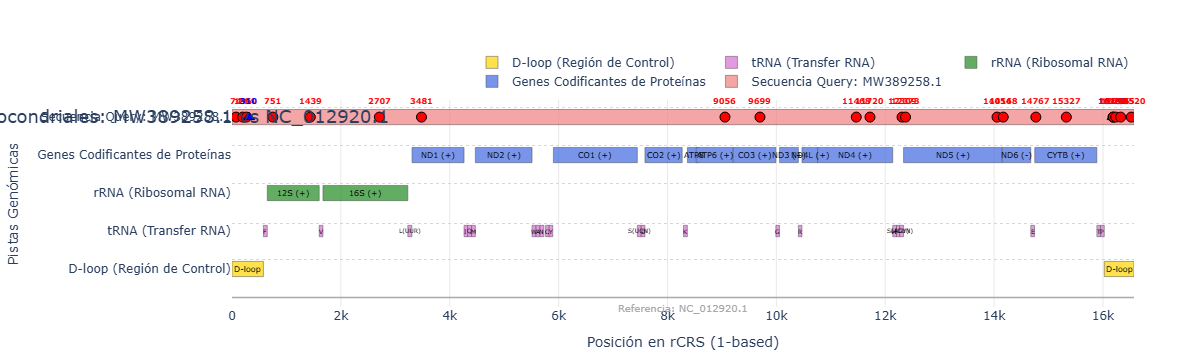

Track Viewer interactivo guardado como: Track_Viewer_MW389258.1_vs_rCRS.html
Track Viewer interactivo generado.

Análisis completado.



In [53]:
# ==============================================================================
# BLOQUE 8: PUNTO DE ENTRADA DEL SCRIPT
# ==============================================================================
# Descripción: Este bloque se ejecuta cuando el script es llamado directamente.
# Define el archivo de consulta de prueba y llama a la función `main`.
# ------------------------------------------------------------------------------

if __name__ == "__main__":
    # Definir la ruta al archivo FASTA de la secuencia query para el análisis
    # Asegúrate de que este archivo exista en la ruta especificada o ajusta la ruta.
    ruta_query_analisis = "secuencias/MW389258_1.fasta"
    
    # Crear un archivo de consulta dummy si no existe, para pruebas rápidas
    if not os.path.exists(ruta_query_analisis):
        print(f"ADVERTENCIA: Archivo de consulta '{ruta_query_analisis}' no encontrado. Creando dummy.")
        os.makedirs(os.path.dirname(ruta_query_analisis), exist_ok=True) # Asegurar que el directorio 'secuencias' existe
        # Secuencia dummy con algunas diferencias respecto a una rCRS hipotética (e.g., primeros 100pb)
        # Para una prueba más significativa, esta secuencia dummy debería tener variantes conocidas.
        dummy_query_seq_content = "GATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACACCCTATTAACCACTCACGGGAGCTCTCCATGCATTTGGTATTTTCGTCTGGGGGGTATGCACGCGATAGCATTGCGAGACGCTGGAGCCGGAGCACCCTATGTCGCAGTATCTGTCTTTGATTCCTG" # ~160pb
        dummy_query_seq_content += "A" * (16569 - len(dummy_query_seq_content) -100) # Relleno
        dummy_query_seq_content += "GATTACAGATTACAGATTACAGATTACAGATTACAGATTACAGATTACA" # Final diferente
        
        with open(ruta_query_analisis, "w") as f:
            f.write(f">Query_Dummy_Sequence\n{dummy_query_seq_content[:16569]}\n") # Truncar a longitud de rCRS por si acaso

    main(query_fasta_file_path=ruta_query_analisis)